# Import

In [74]:
import pandas as pd
from pathlib import Path
import logging
from pythainlp.corpus import thai_stopwords, thai_words
from pythainlp.tokenize import word_tokenize
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from pythainlp.util import dict_trie
from collections import Counter
import pythainlp
import gensim
from gsdmm import MovieGroupProcess
from gensim import corpora, models
from gensim.models import CoherenceModel

In [2]:
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# Define data directory
DATA_DIR = Path("LCS_Chat_Data")

## Extract Data and Combine

In [3]:
def read_chat_file(file_path: Path) -> tuple[dict, pd.DataFrame]:
    """
    Read a single Line chat CSV file and extract metadata and chat content.
    
    Args:
        file_path (Path): Path to the CSV file
        
    Returns:
        tuple: (metadata dict, chat DataFrame)
    """
    try:
        # Read metadata
        metadata = {}
        with open(file_path, 'r', encoding='utf-8') as f:
            metadata['account_name'] = f.readline().strip().split(',')[1]
            metadata['timezone'] = f.readline().strip().split(',')[1]
            metadata['download_date'] = f.readline().strip().split(',')[1]
        
        # Read chat content
        chat_df = pd.read_csv(file_path, skiprows=4)
        
        # Add metadata columns
        chat_df['source_file'] = file_path.stem
        chat_df['account_name'] = metadata['account_name']
        
        # Rename columns
        chat_df.columns = ['sender_type', 'sender_name', 'date', 'time', 
                          'message', 'source_file', 'account_name']
        
        # Convert to datetime
        chat_df['datetime'] = pd.to_datetime(chat_df['date'] + ' ' + chat_df['time'])
        
        logger.info(f"Read {file_path.name}: {len(chat_df)} messages")
        return metadata, chat_df
        
    except Exception as e:
        logger.error(f"Error reading {file_path.name}: {str(e)}")
        raise

def read_all_chats(data_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read all chat files in the directory.
    
    Args:
        data_dir (Path): Directory containing chat files
        
    Returns:
        tuple: (metadata DataFrame, combined chats DataFrame)
    """
    metadata_list = []
    chat_dfs = []
    
    csv_files = list(data_dir.glob("*.csv"))
    logger.info(f"Found {len(csv_files)} CSV files")
    
    for file_path in csv_files:
        try:
            metadata, chat_df = read_chat_file(file_path)
            metadata['source_file'] = file_path.stem
            metadata_list.append(metadata)
            chat_dfs.append(chat_df)
        except Exception as e:
            logger.error(f"Skipping {file_path.name}: {str(e)}")
            
    metadata_df = pd.DataFrame(metadata_list)
    chats_df = pd.concat(chat_dfs, ignore_index=True)
    
    return metadata_df, chats_df

In [4]:
try:
    metadata_df, chats_df = read_all_chats(DATA_DIR)
    
    print("Data Loading Complete!")
    print(f"Total files processed: {len(metadata_df)}")
    print(f"Total messages: {len(chats_df)}")
    
except Exception as e:
    print(f"Error: {str(e)}")

2024-11-27 13:17:47 - INFO - Found 222 CSV files
2024-11-27 13:17:47 - INFO - Read 20240111_20240111_☃️.csv: 17 messages
2024-11-27 13:17:47 - INFO - Read 20241003_20241003_Arm (Kittikhun).csv: 2 messages
2024-11-27 13:17:47 - INFO - Read 20240111_20240111_OAT(36).csv: 4 messages
2024-11-27 13:17:47 - INFO - Read 20240418_20240807_eel.csv: 11 messages
2024-11-27 13:17:47 - INFO - Read 20240116_20240116_Puggardbuibui.csv: 16 messages
2024-11-27 13:17:47 - INFO - Read 20241008_20241010_g.csv: 9 messages
2024-11-27 13:17:47 - INFO - Read 20240819_20240823_Sirabhop.csv: 24 messages
2024-11-27 13:17:47 - INFO - Read 20240728_20240730_เเพนจัง 24.csv: 14 messages
2024-11-27 13:17:47 - INFO - Read 20240315_20240316_gaptnp🦭.csv: 12 messages
2024-11-27 13:17:47 - INFO - Read 20240513_20240908_Pang.csv: 20 messages
2024-11-27 13:17:47 - INFO - Read 20240302_20240302_bonu.csv: 6 messages
2024-11-27 13:17:47 - INFO - Read 20240515_20240516_Phutthikiat.csv: 12 messages
2024-11-27 13:17:47 - INFO - R

Data Loading Complete!
Total files processed: 222
Total messages: 3925


In [5]:
# [Cell 4] - Display basic information
print("Metadata Summary:")
display(metadata_df)

print("\nChat Data Sample:")
display(chats_df.head())

# Basic statistics
print("\nMessages per sender type:")
display(chats_df['sender_type'].value_counts())

print("\nMessages by source file (top 10):")
display(chats_df['source_file'].value_counts().head(10))

Metadata Summary:


account_name timezone     download_date  \
0    LCS Official  '+07:00  2024/11/16 16:05   
1    LCS Official  '+07:00  2024/11/16 15:55   
2    LCS Official  '+07:00  2024/11/16 16:05   
3    LCS Official  '+07:00  2024/11/16 15:57   
4    LCS Official  '+07:00  2024/11/16 16:05   
..            ...      ...               ...   
217  LCS Official  '+07:00  2024/11/16 15:55   
218  LCS Official  '+07:00  2024/11/16 15:57   
219  LCS Official  '+07:00  2024/11/16 15:58   
220  LCS Official  '+07:00  2024/11/16 15:58   
221  LCS Official  '+07:00  2024/11/16 16:00   

                               source_file  
0                     20240111_20240111_☃️  
1        20241003_20241003_Arm (Kittikhun)  
2                20240111_20240111_OAT(36)  
3                    20240418_20240807_eel  
4          20240116_20240116_Puggardbuibui  
..                                     ...  
217                  20240925_20240925_Kae  
218           20240730_20240730_Ittinut R.  
219  20240711_20240718_Nattachote Tungsiri  
220             20240708_20240708_Sittisak  
221                    20240526_20240603_T  

[222 rows x 4 columns]


Chat Data Sample:


sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
2     Account        𝕭𝖔𝖘𝖘  2024/01/11  19:42:08   
3        User          ☃️  2024/01/11  19:43:13   
4     Account        𝕭𝖔𝖘𝖘  2024/01/11  19:43:25   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
2                               สอนทั้งหมด 3 วันครับ  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
4                                     ยังไม่เต็มครับ  20240111_20240111_☃️   

   account_name            datetime  
0  LCS Official 2024-01-11 19:41:38  
1  LCS Official 2024-01-11 19:41:41  
2  LCS Official 2024-01-11 19:42:08  
3  LCS Official 2024-01-11 19:43:13  
4  LCS Official 2024-01-11 19:43:25


Messages per sender type:


sender_type
Account    2074
User       1851
Name: count, dtype: int64


Messages by source file (top 10):


source_file
20240922_20241112_J.                      191
20240614_20240814_no reply                127
20240621_20241004_shana                   101
20240621_20240729_Pegent                  101
20240111_20240221_8ธนาวดี                  92
20240911_20240913_❤️ maew 🌼🌸               75
20240526_20240625_Sb.                      65
20240211_20240223_ไชยชนะ 🐕                 58
20240603_20240606_😳                        56
20240216_20240326_Pangponddddddpingggg     55
Name: count, dtype: int64

Message Timing Analysis:


<Axes: title={'center': 'Messages by Hour'}, xlabel='hour'>


Top Senders:


sender_name
𝕭𝖔𝖘𝖘                       1927
ข้อความตอบกลับอัตโนมัติ     113
J.                          106
Unknown                      62
no reply                     54
shana                        47
Pegent                       44
❤️ maew 🌼🌸                   44
8ธนาวดี                      38
Sb.                          37
Name: message, dtype: int64


Conversation Time Spans:


datetime                    
                                                   min                 max
source_file                                                               
20231202_20240908_สัจจะ28 TTB Bank 2024-09-08 11:30:04 2024-09-08 11:30:24
20231205_20241113_Anchalee_s       2023-12-05 18:01:58 2024-11-13 10:10:26
20231211_20240218_KB               2023-12-11 18:13:26 2024-02-18 18:07:01
20231212_20231215_Pom              2023-12-12 10:57:35 2023-12-15 04:03:13
20231214_20231214_แพรจ๋า           2023-12-14 20:24:25 2023-12-14 20:26:28
...                                                ...                 ...
20241111_20241115_Oni              2024-11-11 16:43:14 2024-11-15 14:14:56
20241112_20241115_Panya Phusapan   2024-11-12 19:30:33 2024-11-15 18:08:33
20241113_20241113_Fluke Chairoj    2024-11-13 11:40:31 2024-11-13 11:40:55
20241113_20241113_Paphon           2024-11-13 18:39:51 2024-11-13 18:44:51
20241114_20241114_Phanu            2024-11-14 10:42:42 2024-11-14 11:17:40

[222 rows x 2 columns]

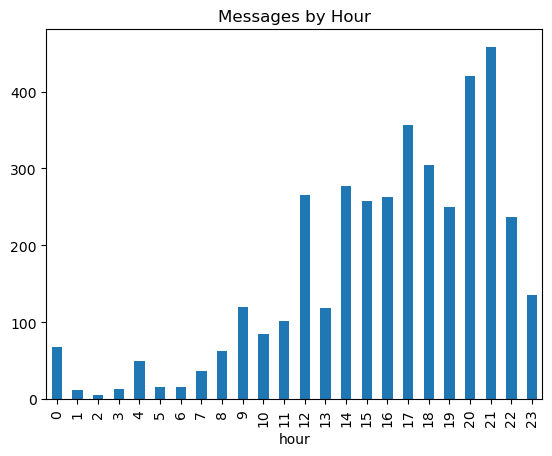

In [6]:
# [Cell 5] - Basic analysis functions
def analyze_chat_patterns(df: pd.DataFrame) -> None:
    """Display basic chat patterns and statistics"""
    
    print("Message Timing Analysis:")
    df['hour'] = df['datetime'].dt.hour
    hourly_stats = df.groupby('hour')['message'].count()
    display(hourly_stats.plot(kind='bar', title='Messages by Hour'))
    
    print("\nTop Senders:")
    sender_stats = df.groupby('sender_name')['message'].count().sort_values(ascending=False)
    display(sender_stats.head(10))
    
    print("\nConversation Time Spans:")
    time_span = df.groupby('source_file').agg({
        'datetime': ['min', 'max']
    })
    display(time_span)

# Run analysis
analyze_chat_patterns(chats_df)

In [7]:
metadata_df.head()

account_name timezone     download_date                        source_file
0  LCS Official  '+07:00  2024/11/16 16:05               20240111_20240111_☃️
1  LCS Official  '+07:00  2024/11/16 15:55  20241003_20241003_Arm (Kittikhun)
2  LCS Official  '+07:00  2024/11/16 16:05          20240111_20240111_OAT(36)
3  LCS Official  '+07:00  2024/11/16 15:57              20240418_20240807_eel
4  LCS Official  '+07:00  2024/11/16 16:05    20240116_20240116_Puggardbuibui

In [8]:
chats_df.shape

(3925, 9)

In [9]:
chats_df.head()

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
2     Account        𝕭𝖔𝖘𝖘  2024/01/11  19:42:08   
3        User          ☃️  2024/01/11  19:43:13   
4     Account        𝕭𝖔𝖘𝖘  2024/01/11  19:43:25   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
2                               สอนทั้งหมด 3 วันครับ  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
4                                     ยังไม่เต็มครับ  20240111_20240111_☃️   

   account_name            datetime  hour  
0  LCS Official 2024-01-11 19:41:38    19  
1  LCS Official 2024-01-11 19:41:41    19  
2  LCS Official 2024-01-11 19:42:08    19  
3  LCS Official 2024-01-11 19:43:13    19  
4  LCS Official 2024-01-11 19:43:25    19

# Preprocessing

## Cleaning

In [10]:
# Clean Comments
def clean_comments_data(df_comments):
    print(f"Original number of rows: {len(df_comments)}")

    # Convert any dictionary columns to strings
    for col in df_comments.columns:
        if df_comments[col].dtype == 'object':
            df_comments[col] = df_comments[col].apply(lambda x: str(x) if isinstance(x, dict) else x)

    # Remove exact duplicates
    df_no_exact_dupes = df_comments.drop_duplicates()
    print(f"Number of rows after removing exact duplicates: {len(df_no_exact_dupes)}")

    # Remove content duplicates within each post
    df_clean = df_no_exact_dupes.drop_duplicates(subset=['post_id', 'comment_message'])
    print(f"Final number of rows after removing content duplicates: {len(df_clean)}")

    return df_clean

# Clean Text
def clean_text(text, remove_urls=True, remove_username=True, remove_html_tag=True, remove_punctuation=True, remove_newlines=True, remove_emojis=True, remove_extra_spaces=True):
    if not isinstance(text, str):
        return ""
    # Remove URLs
    if remove_urls:
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove @username
    if remove_username:
        text = re.sub(r'@\w+', '', text)

    # Remove html tag
    if remove_html_tag:
        text = re.sub(r'<.*?>', '', text)

    # Remove #hashtag
    if remove_punctuation:
        text = re.sub(r'[^\u0E00-\u0E7F\w\s]', '', text)
    
    # Remove Newlines
    if remove_newlines:
        text = text.replace('\n', '')
    
    # Remove Emojis
    if remove_emojis:
        text = re.sub(
            r'[^\u0E00-\u0E7F\w\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', 
            '', 
            text
        )
    # Remove Extra Spaces
    if remove_extra_spaces:
        text = re.sub(r' +', ' ', text)
    
    text = text.strip()
    
    return text if text else np.nan

def tokenize_text(text, custom_dict):
    # Tokenize with whitespace, then filter out empty strings
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=True, custom_dict=custom_dict)
    return [token for token in tokens if token.strip()]  # Remove empty or whitespace-only tokens

# Remove Stopword
def remove_stopwords(tokens, stop_words):
    return [word for word in tokens if word.lower() not in stop_words]


In [11]:
def process_chat_messages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process chat messages with cleaning, tokenization, and stopword removal.
    
    Args:
        df (pd.DataFrame): Chat DataFrame with 'message' column
        
    Returns:
        pd.DataFrame: DataFrame with processed text columns
    """
    logger.info("Starting text processing...")
    
    # Create a copy to preserve original data
    processed_df = df.copy()
    
    # Step 1: Clean text
    logger.info("Cleaning text...")
    processed_df['cleaned_message'] = processed_df['message'].apply(
        lambda x: clean_text(
            x,
            remove_urls=True,
            remove_username=True,
            remove_html_tag=True,
            remove_punctuation=True,
            remove_newlines=True,
            remove_emojis=True,
            remove_extra_spaces=True
        )
    )
    
    # Step 2: Tokenization
    logger.info("Tokenizing text...")
    custom_dict = set()  # Add custom words if needed
    processed_df['tokenized_message'] = processed_df['cleaned_message'].apply(
        lambda x: tokenize_text(str(x), custom_dict)
    )
    
    # Step 3: Remove stopwords
    logger.info("Removing stopwords...")
    stop_words = set(thai_stopwords())
    processed_df['processed_message'] = processed_df['tokenized_message'].apply(
        lambda x: remove_stopwords(x, stop_words)
    )
    
    # Step 4: Remove duplicates (modified to handle lists)
    logger.info("Removing duplicates...")
    # Convert lists to strings for deduplication
    processed_df['message_str'] = processed_df['message'].astype(str)
    processed_df = processed_df.drop_duplicates(subset=['message_str', 'sender_type', 'datetime'])
    processed_df = processed_df.drop(columns=['message_str'])
    
    # Step 5: Add length statistics
    processed_df['token_count'] = processed_df['processed_message'].apply(len)
    processed_df['char_count'] = processed_df['message'].str.len()
    
    logger.info("Text processing completed!")
    
    return processed_df


In [12]:
# run  
processed_df = process_chat_messages(chats_df)
processed_df.head()

2024-11-27 13:17:47 - INFO - Starting text processing...
2024-11-27 13:17:47 - INFO - Cleaning text...
2024-11-27 13:17:48 - INFO - Tokenizing text...
2024-11-27 13:17:48 - INFO - Removing stopwords...
2024-11-27 13:17:48 - INFO - Removing duplicates...
2024-11-27 13:17:48 - INFO - Text processing completed!


sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
2     Account        𝕭𝖔𝖘𝖘  2024/01/11  19:42:08   
3        User          ☃️  2024/01/11  19:43:13   
4     Account        𝕭𝖔𝖘𝖘  2024/01/11  19:43:25   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
2                               สอนทั้งหมด 3 วันครับ  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
4                                     ยังไม่เต็มครับ  20240111_20240111_☃️   

   account_name            datetime  hour  \
0  LCS Official 2024-01-11 19:41:38    19   
1  LCS Official 2024-01-11 19:41:41    19   
2  LCS Official 2024-01-11 19:42:08    19   
3  LCS Official 2024-01-11 19:43:13    19   
4  LCS Official 2024-01-11 19:43:25    19   

                                     cleaned_message  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...   
1                                          คุณส่งรูป   
2                               สอนทั้งหมด 3 วันครับ   
3                                    เต็มหรือยังครับ   
4                                     ยังไม่เต็มครับ   

                                   tokenized_message  \
0  [เวิร์ก, ชิป, นี้, อ่ะ, ครับ, คือ, สอน, ทั้งหม...   
1                                    [คุณ, ส่ง, รูป]   
2                       [สอน, ทั้งหมด, 3, วัน, ครับ]   
3                              [เต็ม, หรือยัง, ครับ]   
4                             [ยัง, ไม่, เต็ม, ครับ]   

                      processed_message  token_count  char_count  
0  [เวิร์ก, ชิป, อ่ะ, สอน, 3, 3, เลือก]            7          81  
1                                 [รูป]            1           9  
2                              [สอน, 3]            2          20  
3                                [เต็ม]            1          15  
4                                [เต็ม]            1          14

In [13]:
# Analyze by sender type
sender_stats = processed_df.groupby('sender_type').agg({
    'token_count': ['mean', 'count'],
    'char_count': ['mean'],
    'message': 'count'
}).round(2)

print("\nStatistics by sender type:")
display(sender_stats)

# Most common tokens
all_tokens = [token for tokens in processed_df['processed_message'] for token in tokens]
token_freq = pd.Series(all_tokens).value_counts()

print("\nTop 20 most common tokens:")
display(token_freq.head(20))


Statistics by sender type:


token_count       char_count message
                   mean count       mean   count
sender_type                                     
Account            3.33  1995      37.05    1995
User               3.05  1836      26.13    1836


Top 20 most common tokens:


รูป          374
เรียน        334
ค่าย         204
สมัคร        195
ตัวต่อตัว    189
สวัสดี       162
ไหม          159
Discord      156
ขอบคุณ       154
สอบถาม       147
น้อง         144
พี่          133
ผม           120
สนใจ         113
ทำ           100
เข้าร่วม      94
สอน           91
Link          86
เดี๋ยว        81
ข้อมูล        80
Name: count, dtype: int64

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


In [15]:
def generate_wordcloud(df: pd.DataFrame, column='tokenized_message', user_only=True):
    """
    Generate word cloud from specified column of DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to use for word cloud (default: 'tokenized_message')
        user_only (bool): Whether to filter for user messages only (default: True)
    
    Returns:
        matplotlib.figure.Figure: Word cloud figure
    """
    # Filter for user messages if requested
    if user_only:
        df = df[df['sender_type'] == 'User']
    
    # Process text for wordcloud
    all_words = []
    for tokens in df[column]:
        if isinstance(tokens, list):
            all_words.extend(tokens)
    
    # Join words for word cloud
    processed_text = ' '.join(all_words)
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=1200, 
        height=800, 
        background_color='white', 
        regexp=r"[ก-๙a-zA-Z0-9']+",  # Consider only Thai and English characters
        collocations=False,  # Turn off collocations
        font_path='/Users/Workspace/CODE-WorkingSpace/Pantip-Scraping/Streamlit-Web/SukhumvitSet Medium.ttf',
        min_font_size=10,
        max_font_size=150
    ).generate(processed_text)
    
    # Create and return the figure
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    # Add title based on settings
    title = f"Word Cloud - {'User ' if user_only else ''}Messages"
    ax.set_title(title, pad=20, fontsize=16)
    
    return fig

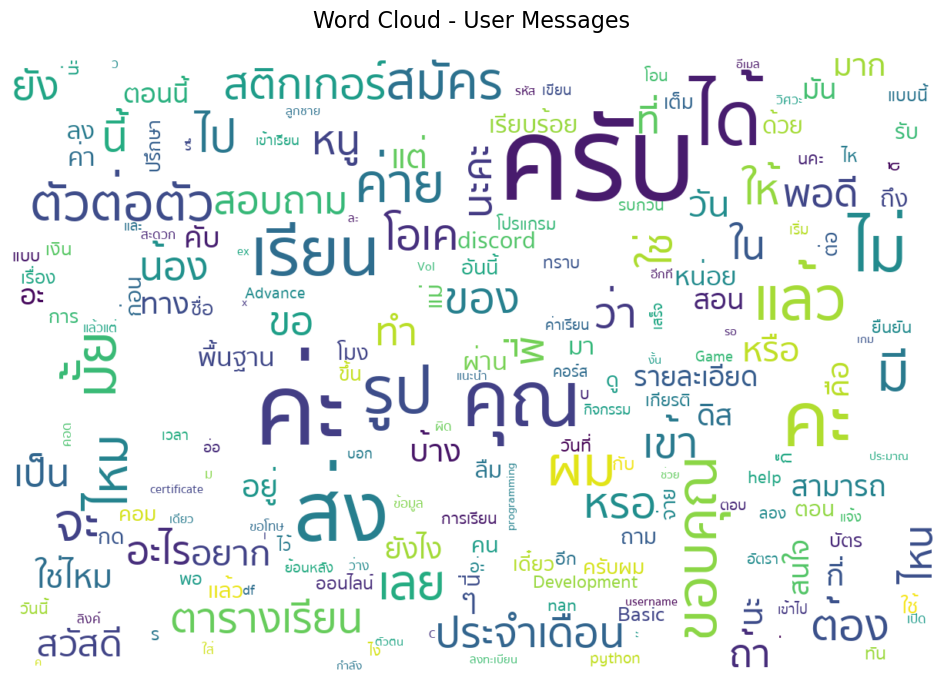

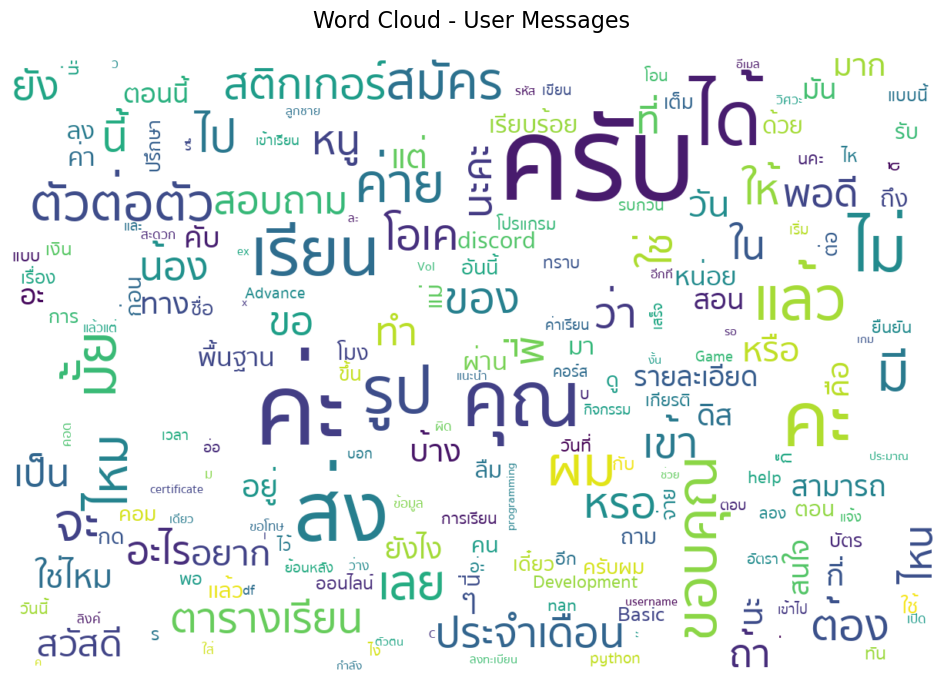

In [16]:
generate_wordcloud(processed_df)

## Remove Stopword

In [17]:
# [Cell - Stop Words Configuration]
# Define custom stop words
CUSTOM_STOP_WORDS = {
    # Common Thai words
    'ครับ', 'ค่ะ', 'นะ', 'ค้าบ', 'คับ', 'คะ', 'น้า', 'นะคะ', 'นะครับ',
    'ๆ', 'ไป', 'มา', 'ให้', 'ได้', 'ที่', 'มี', 'เป็น', 'แล้ว', 'จะ',
    'อยู่', 'ก็', 'ไม่', 'มัน', 'เรา', 'เขา', 'ของ', 'กับ', 'แต่',
    
    # Line specific words
    'sticker', 'photo', 'video', 'file', 'location', 'voice message',
    'คุณ', 'ส่ง', 'รูป', 'สติกเกอร์', 'ไฟล์', 'วิดีโอ', 'โลเคชัน',
    
    # Common English words
    'the', 'is', 'are', 'was', 'were', 'a', 'an', 'and', 'or', 'but',
    'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
    
}


# EDA

## Trigram of context

In [18]:
def generate_trigram_wordcloud(df: pd.DataFrame, user_only=True):
    """
    Generate trigram word cloud from tokenized messages.
    
    Args:
        df (pd.DataFrame): Input DataFrame with tokenized messages
        user_only (bool): Whether to filter for user messages only (default: True)
    
    Returns:
        matplotlib.figure.Figure: Word cloud figure
    """
    # Filter for user messages if requested
    if user_only:
        df = df[df['sender_type'] == 'User']
    
    # Generate trigrams from tokenized messages
    trigrams = []
    for tokens in df['tokenized_message']:
        if isinstance(tokens, list) and len(tokens) >= 3:
            # Generate trigrams for each message
            message_trigrams = [
                ' '.join(tokens[i:i+3]) 
                for i in range(len(tokens)-2)
            ]
            trigrams.extend(message_trigrams)
    
    # Count trigram frequencies
    trigram_freq = Counter(trigrams)
    
    # Generate word cloud from trigram frequencies
    wordcloud = WordCloud(
        width=1200, 
        height=800, 
        background_color='white', 
        regexp=r"[ก-๙a-zA-Z0-9'\s]+",  # Consider Thai, English characters and spaces
        collocations=False,
        font_path='/Users/Workspace/CODE-WorkingSpace/Pantip-Scraping/Streamlit-Web/SukhumvitSet Medium.ttf',
        min_font_size=10,
        max_font_size=150
    ).generate_from_frequencies(trigram_freq)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    # Add title
    title = f"Trigram Word Cloud - {'User ' if user_only else ''}Messages"
    ax.set_title(title, pad=20, fontsize=16)
    
    # Display top trigrams
    print(f"\nTop 20 trigrams in {'user' if user_only else 'all'} messages:")
    top_trigrams = pd.DataFrame(
        trigram_freq.most_common(20),
        columns=['Trigram', 'Count']
    )
    display(top_trigrams)
    
    return fig


Top 20 trigrams in user messages:


Trigram  Count
0                คุณ ส่ง รูป    167
1          คุณ ส่ง สติกเกอร์     72
2              ใช่ มั้ย ครับ     21
3                ได้ มั้ย คะ     17
4               ได้ ไหม ครับ     15
5   รายละเอียด ของ ตัวต่อตัว     15
6           Basic to Advance     14
7         อัตรา ค่าเรียน ของ     13
8     ค่าเรียน ของ ตัวต่อตัว     13
9       ปรึกษา ของ ตัวต่อตัว     13
10               ใช่ มั้ย คะ     13
11            ไม่ มี พื้นฐาน     11
12             ได้ มั้ย ครับ     11
13            ค่ะ ขอบคุณ ค่ะ     11
14                ได้ ไหม คะ     10
15              ขอบคุณ มาก ๆ     10
16              ไหน หรอ ครับ      9
17               โอเค ร ครับ      8
18               ยัง ไม่ ได้      7
19           to Advance Game      7

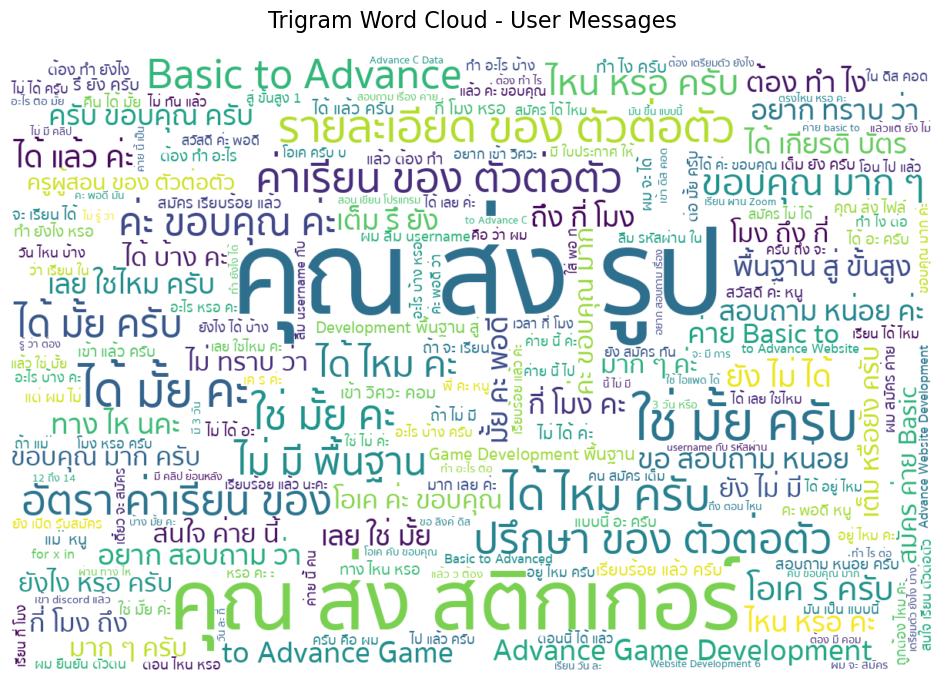

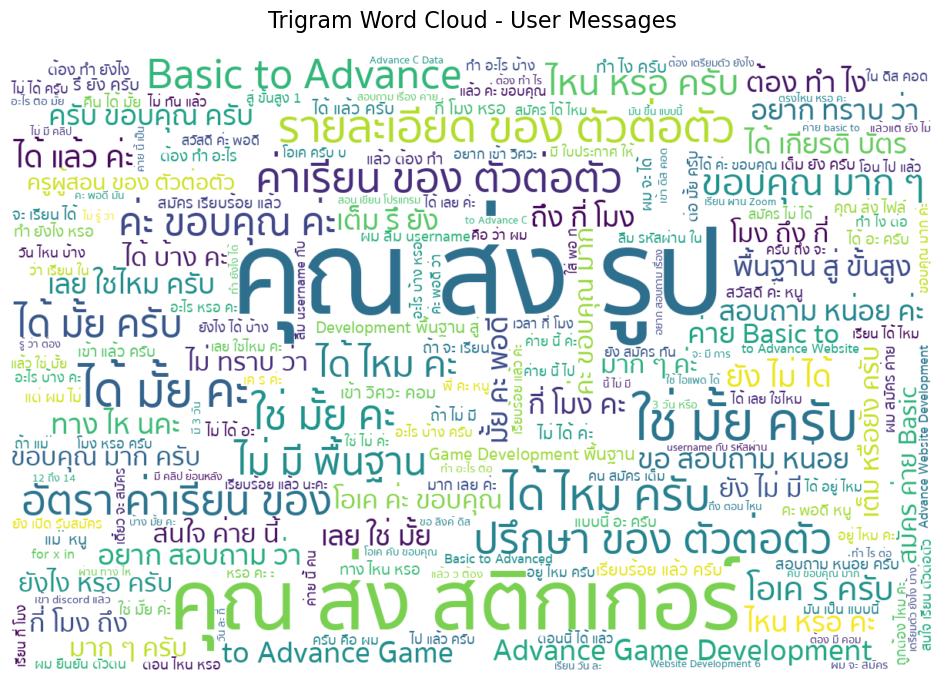

In [19]:
generate_trigram_wordcloud(processed_df)

In [20]:
def generate_ngram_wordcloud(df: pd.DataFrame, 
                           n_gram: int = 1,
                           column: str = 'tokenized_message',
                           user_only: bool = True,
                           stop_words: set = CUSTOM_STOP_WORDS,
                           additional_stop_words: set = None,
                           min_freq: int = 2):
    """
    Generate word cloud for n-grams from specified column with stop words filtering.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        n_gram (int): Size of n-gram (1 for unigram, 2 for bigram, 3 for trigram, etc.)
        column (str): Column name to use for word cloud
        user_only (bool): Whether to filter for user messages only
        stop_words (set): Base stop words to filter out
        additional_stop_words (set): Additional stop words to filter out
        min_freq (int): Minimum frequency for n-gram to be included
        
    Returns:
        matplotlib.figure.Figure: Word cloud figure
    """
    logger.info(f"Generating {n_gram}-gram word cloud...")
    
    # Combine stop words
    all_stop_words = stop_words.copy()
    if additional_stop_words:
        all_stop_words.update(additional_stop_words)
    
    # Filter for user messages if requested
    if user_only:
        df = df[df['sender_type'] == 'User']
    
    def generate_ngrams(tokens: list, n: int) -> list:
        """Generate n-grams from token list"""
        return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    
    # Process text for wordcloud
    all_ngrams = []
    for tokens in df[column]:
        if isinstance(tokens, list) and len(tokens) >= n_gram:
            # Filter out tokens containing stop words
            filtered_tokens = [token for token in tokens if token.lower() not in all_stop_words]
            if len(filtered_tokens) >= n_gram:
                all_ngrams.extend(generate_ngrams(filtered_tokens, n_gram))
    
    # Create frequency dictionary
    ngram_freq = Counter(all_ngrams)
    
    # Filter by minimum frequency
    ngram_freq = {k: v for k, v in ngram_freq.items() if v >= min_freq}
    
    if not ngram_freq:
        logger.warning(f"No {n_gram}-grams found with minimum frequency {min_freq}")
        return None
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=1200, 
        height=800, 
        background_color='white', 
        regexp=r"[ก-๙a-zA-Z0-9'\s]+",
        collocations=False,
        font_path='/Users/Workspace/CODE-WorkingSpace/Pantip-Scraping/Streamlit-Web/SukhumvitSet Medium.ttf',
        min_font_size=10,
        max_font_size=150
    ).generate_from_frequencies(ngram_freq)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    # Add title
    title = f"{n_gram}-gram Word Cloud - {'User ' if user_only else ''}Messages"
    ax.set_title(title, pad=20, fontsize=16)
    
    # Display n-gram frequency statistics
    print(f"\nTop 30 {n_gram}-grams:")
    top_ngrams = pd.DataFrame(
        sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:30],
        columns=[f'{n_gram}-gram', 'Count']
    )
    display(top_ngrams)
    
    return fig

2024-11-27 13:17:51 - INFO - Generating 3-gram word cloud...



Top 30 3-grams:


3-gram  Count
0   อัตรา ค่าเรียน ตัวต่อตัว     13
1         Basic Advance Game      7
2   Advance Game Development      7
3                ถึง กี่ โมง      6
4                 ทาง ไห นคะ      6
5              สนใจ ค่าย นี้      6
6            อยาก สอบถาม ว่า      6
7        พื้นฐาน สู่ ขั้นสูง      6
8            ขอ สอบถาม หน่อย      6
9              อยาก ทราบ ว่า      6
10              เลย ใช่ มั้ย      6
11               เต็ม รึ ยัง      6
12                ต้อง ทำ ไง      6
13             ผม สมัคร ค่าย      5
14          สมัคร ค่าย Basic      5
15        ค่าย Basic Advance      5
16               กี่ โมง ถึง      5
17               โมง ถึง กี่      5
18  Game Development พื้นฐาน      5
19   Development พื้นฐาน สู่      5
20               กี่ โมง หรอ      5
21            เข้า วิศวะ คอม      5
22           ผม ลืม username      4
23              ต้อง ทำ อะไร      4
24             ต้อง ทำ ยังไง      4
25              ทำ ยังไง หรอ      4
26            ขอบคุณ มาก เลย      4
27               ทาง ไหน หรอ      4
28              ทำ อะไร บ้าง      4
29                 แม่ ่ หนู      4

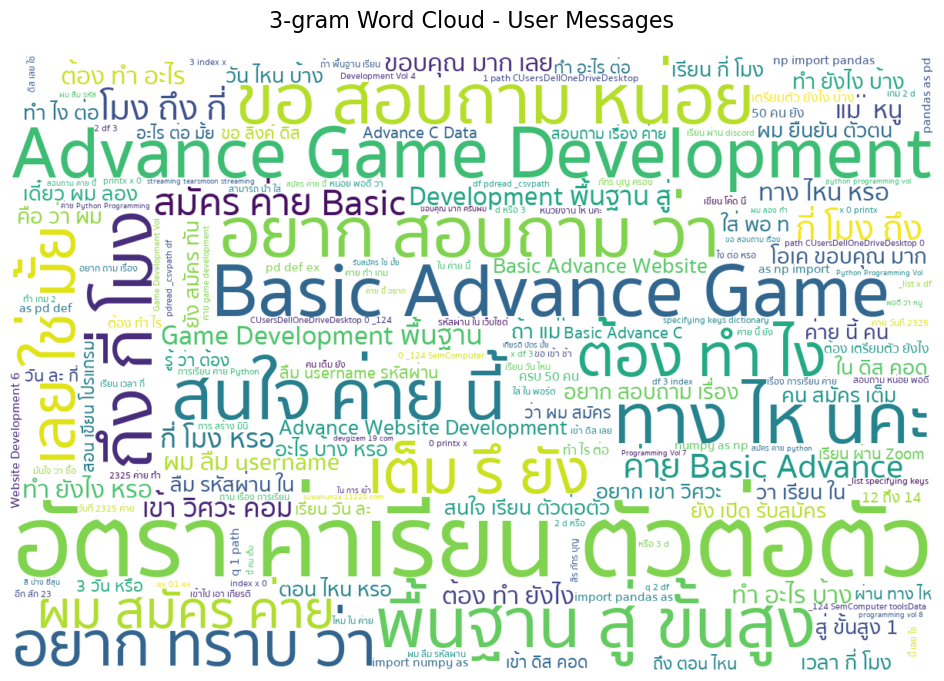

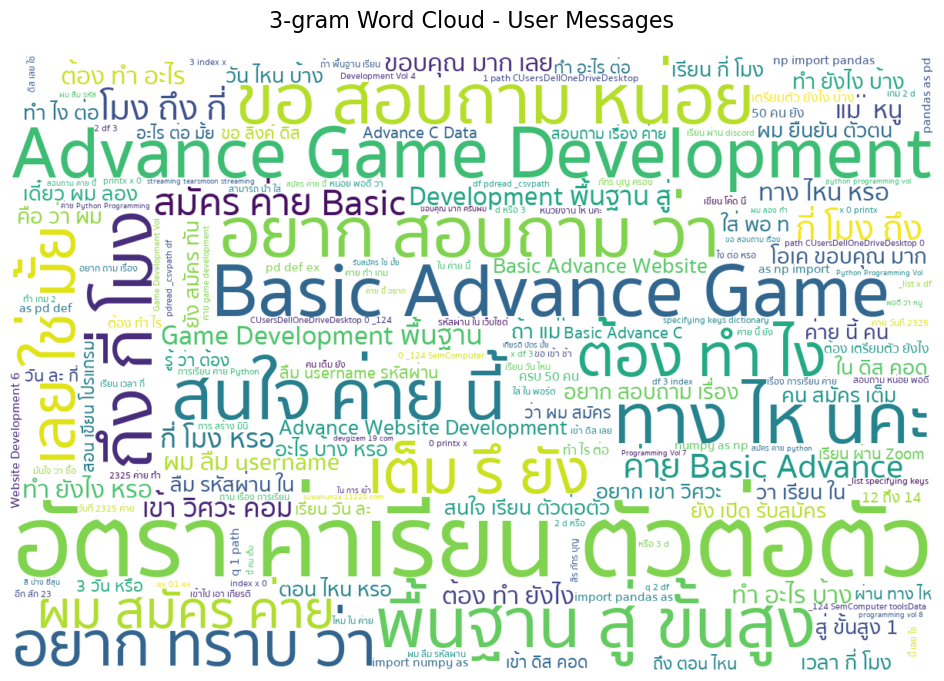

In [21]:
generate_ngram_wordcloud(processed_df, n_gram=3)

## Similarity Analysis

In [22]:
import pandas as pd
import re
from collections import Counter
from difflib import SequenceMatcher
import numpy as np
from typing import List, Tuple, Dict

def normalize_thai_text(text: str) -> str:
    """
    Normalize Thai text by:
    1. Converting common variations to standard forms
    2. Removing redundant spaces and characters
    """
    # Dictionary of common variations
    variations = {
        'ครับ': '',
        'คะ': '',
        'ค่ะ': '',
        'มั้ย': 'ไหม',
        'เปล่า': 'ไหม',
        'มาย': 'ไหม',
        '?': '',
        '??': '',
        '???': '',
    }
    
    # Convert text to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z0-9\s]', ' ', str(text))
    
    # Apply variations replacement
    for old, new in variations.items():
        text = text.replace(old, new)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def calculate_similarity(text1: str, text2: str) -> float:
    """
    Calculate similarity between two strings using SequenceMatcher
    """
    return SequenceMatcher(None, text1, text2).ratio()

def group_similar_questions(questions: List[str], similarity_threshold: float = 0.8) -> Dict[str, List[str]]:
    """
    Group similar questions together using similarity threshold
    """
    groups = {}
    processed_questions = set()

    # Sort questions by length to prefer shorter representatives
    questions_sorted = sorted(questions, key=len)

    for q1 in questions_sorted:
        if q1 in processed_questions:
            continue

        # Create new group with q1 as representative
        similar_questions = [q1]
        processed_questions.add(q1)

        # Find similar questions
        for q2 in questions_sorted:
            if q2 not in processed_questions and calculate_similarity(q1, q2) >= similarity_threshold:
                similar_questions.append(q2)
                processed_questions.add(q2)

        groups[q1] = similar_questions

    return groups

def analyze_questions_with_similarity(df: pd.DataFrame, similarity_threshold: float = 0.8) -> pd.DataFrame:
    """
    Analyze questions with similarity grouping
    """
    # Filter questions and normalize text
    questions_df = df[df['message'].apply(lambda x: any(marker in x for marker in ['ไหม', 'มั้ย', 'หรือ', '?']))].copy()
    questions_df['normalized_text'] = questions_df['message'].apply(normalize_thai_text)
    
    # Group similar questions
    question_groups = group_similar_questions(
        questions_df['normalized_text'].unique().tolist(),
        similarity_threshold
    )
    
    # Count frequencies for each group
    group_counts = {}
    for representative, similar_questions in question_groups.items():
        count = questions_df['normalized_text'].isin(similar_questions).sum()
        group_counts[representative] = {
            'count': count,
            'variations': similar_questions,
            'variation_count': len(similar_questions)
        }
    
    # Create results DataFrame
    results = []
    for rep, data in group_counts.items():
        results.append({
            'representative_question': rep,
            'count': data['count'],
            'variation_count': data['variation_count'],
            'variations': ' | '.join(data['variations'])
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('count', ascending=False)
    
    return results_df

# Function to display analysis results
def display_question_analysis(df: pd.DataFrame):
    # Analyze questions
    results = analyze_questions_with_similarity(df, similarity_threshold=0.8)
    
    print("\nTop Questions Analysis:")
    print("=" * 100)
    for idx, row in results.head(60).iterrows():
        print(f"\nQuestion Group {idx + 1}:")
        print(f"Main Question: {row['representative_question']}")
        print(f"Total Count: {row['count']}")
        print(f"Number of Variations: {row['variation_count']}")
        print("Variations:")
        variations = row['variations'].split(' | ')
        for v in variations:
            print(f"  - {v}")
        print("-" * 40)
    
    # Basic statistics
    total_messages = len(df)
    total_question_groups = len(results)
    total_questions = results['count'].sum()
    
    print("\nSummary Statistics:")
    print(f"Total messages: {total_messages}")
    print(f"Total question groups: {total_question_groups}")
    print(f"Total questions: {total_questions}")
    print(f"Average variations per question: {results['variation_count'].mean():.2f}")
    print(f"Percentage of messages that are questions: {(total_questions/total_messages)*100:.2f}%")


In [23]:
# Clean chat_df['sender_type'] if it not contain 'User' 
chats_df = chats_df[chats_df['sender_type'] == 'User']

In [24]:
display_question_analysis(chats_df)


Top Questions Analysis:

Question Group 9:
Main Question: เต็มหรือยัง
Total Count: 3
Number of Variations: 1
Variations:
  - เต็มหรือยัง
----------------------------------------

Question Group 3:
Main Question: ได้ไหม
Total Count: 3
Number of Variations: 3
Variations:
  - ได้ไหม
  - จะได้ไหม
  - ได้รับไหม
----------------------------------------

Question Group 2:
Main Question: ใช่ไหม
Total Count: 3
Number of Variations: 2
Variations:
  - ใช่ไหม
  - ใช่ผมไหม
----------------------------------------

Question Group 23:
Main Question: พรุ่งนี้ได้ไหม
Total Count: 2
Number of Variations: 2
Variations:
  - พรุ่งนี้ได้ไหม
  - พรุ่งนี้ได้ใช่ไหม
----------------------------------------

Question Group 28:
Main Question: พิมชื่อเลยใช่ไหม
Total Count: 2
Number of Variations: 2
Variations:
  - พิมชื่อเลยใช่ไหม
  - พิมพ์ชื่อน้อง เลยใช่ไหม
----------------------------------------

Question Group 31:
Main Question: มีใบประกาศให้ไหม
Total Count: 2
Number of Variations: 1
Variations:
  - มีใบประกาศ

In [25]:
import pandas as pd
import re
from collections import Counter
from difflib import SequenceMatcher
import numpy as np
from typing import List, Tuple, Dict, Union

def create_analysis_dataframe(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert the analysis results into a structured DataFrame
    """
    data = []
    
    for idx, row in results_df.iterrows():
        group_data = {
            'group_id': idx + 1,
            'main_question': row['representative_question'],
            'total_count': row['count'],
            'variation_count': row['variation_count'],
            'variations': row['variations'],
        }
        
        # Add derived features
        group_data['question_type'] = categorize_question(row['representative_question'])
        group_data['has_question_mark'] = bool(re.search(r'[?]|ไหม|มั้ย|เปล่า|หรือ', row['representative_question']))
        group_data['question_length'] = len(row['representative_question'])
        
        data.append(group_data)
    
    return pd.DataFrame(data)

def categorize_question(text: str) -> str:
    """
    Categorize the type of question
    """
    text = text.lower()
    
    categories = {
        'YES_NO': [r'ไหม$', r'มั้ย$', r'เปล่า$', r'หรือ$', r'ใช่'],
        'AVAILABILITY': [r'เต็ม', r'ยังเปิด', r'ยังรับ', r'สมัครทัน'],
        'TIME': [r'เมื่อไหร่', r'วันไหน', r'ตอนไหน', r'กี่โมง', r'พรุ่งนี้'],
        'PROCESS': [r'ยังไง', r'อย่างไร', r'วิธี', r'ขั้นตอน'],
        'REQUIREMENT': [r'ต้องมี', r'ต้องใช้', r'จำเป็น', r'พื้นฐาน'],
        'PAYMENT': [r'ราคา', r'จ่าย', r'โอน', r'บาท', r'ชำระ'],
        'TECHNICAL': [r'ออนไลน์', r'discord', r'zoom', r'โปรแกรม']
    }
    
    for category, patterns in categories.items():
        if any(re.search(pattern, text) for pattern in patterns):
            return category
    
    return 'OTHER'

def analyze_and_convert_to_df(df: pd.DataFrame, similarity_threshold: float = 0.8) -> pd.DataFrame:
    """
    Analyze questions and convert results to a structured DataFrame
    """
    # First get the analysis results
    results = analyze_questions_with_similarity(df, similarity_threshold)
    
    # Convert to structured DataFrame
    structured_df = create_analysis_dataframe(results)
    
    return structured_df

def display_enhanced_analysis(df: pd.DataFrame):
    """
    Display enhanced analysis of the questions DataFrame
    """
    # Get structured analysis
    analysis_df = analyze_and_convert_to_df(df)
    
    print("\n=== Question Analysis Report ===")
    
    # Category Distribution
    print("\n1. Question Category Distribution:")
    category_counts = analysis_df['question_type'].value_counts()
    for category, count in category_counts.items():
        print(f"{category}: {count} ({count/len(analysis_df)*100:.1f}%)")
    
    # Most Common Questions
    print("\n2. Top Questions by Frequency:")
    top_questions = analysis_df.nlargest(100, 'total_count')
    for _, row in top_questions.iterrows():
        print(f"- {row['main_question']} (Count: {row['total_count']})")
    
    # Questions with Most Variations
    print("\n3. Questions with Most Variations:")
    var_questions = analysis_df.nlargest(5, 'variation_count')
    for _, row in var_questions.iterrows():
        print(f"- {row['main_question']} (Variations: {row['variation_count']})")
    
    # Length Statistics
    print("\n4. Question Length Statistics:")
    print(f"Average length: {analysis_df['question_length'].mean():.1f} characters")
    print(f"Shortest: {analysis_df.loc[analysis_df['question_length'].idxmin(), 'main_question']}")
    print(f"Longest: {analysis_df.loc[analysis_df['question_length'].idxmax(), 'main_question']}")
    
    # Summary Statistics
    print("\n5. Summary Statistics:")
    print(f"Total unique questions: {len(analysis_df)}")
    print(f"Total question instances: {analysis_df['total_count'].sum()}")
    print(f"Average variations per question: {analysis_df['variation_count'].mean():.2f}")
    
    return analysis_df

In [26]:
df = chats_df
analysis_df = display_enhanced_analysis(df)


=== Question Analysis Report ===

1. Question Category Distribution:
YES_NO: 211 (73.3%)
OTHER: 44 (15.3%)
TECHNICAL: 11 (3.8%)
AVAILABILITY: 7 (2.4%)
PAYMENT: 5 (1.7%)
TIME: 5 (1.7%)
REQUIREMENT: 3 (1.0%)
PROCESS: 2 (0.7%)

2. Top Questions by Frequency:
- เต็มหรือยัง (Count: 3)
- ได้ไหม (Count: 3)
- ใช่ไหม (Count: 3)
- พรุ่งนี้ได้ไหม (Count: 2)
- พิมชื่อเลยใช่ไหม (Count: 2)
- มีใบประกาศให้ไหม (Count: 2)
- ยังเปิดอยู่ไหมคับ (Count: 2)
- ค่ายวันที่23 25เป็นค่ายทำเกม2dหรือ3d (Count: 2)
- มีการสร้างมินิโปรเจค ไหม ในค่ายนี้ (Count: 2)
- ออนไลน์ไหม (Count: 2)
- ยังสมัครทันอยู่ไหม (Count: 2)
- แล้ว คอมที่จะเรียน ต้องลงโปแกรม ก่อนไหม (Count: 1)
- สมัครเเล้วขึ้นเเบบนี้ผมต้องส่งอะไรให้ไหม (Count: 1)
- ตอนนี้แคมป์ยังสามารถสมัครได้อยู่ไหมครัับ (Count: 1)
- พอดีว่าหนูติดธุระถ้าตาม task ย้อนหลังได้ไหม (Count: 1)
- ชำระเงินแล้วเข้าดิสแล้วต้องทำไรต่อไหมคั้ย (Count: 1)
- ชำระเงินหลังขากเรียนเสร็จต่อวัน หรือยังไง (Count: 1)
- c ความรู้นี้ ต้องใช้ในการเรียนวิศว คอมไหม (Count: 1)
- ถ้าไม่สะดวกเข้าตามเว

## Topic Theme Analysis

In [27]:
import pandas as pd
import re

def parse_question_groups(text_content):
    # Initialize lists to store data
    data = []
    
    # Split text into groups
    groups = text_content.split("Question Group")[1:]  # Skip the header
    
    for group in groups:
        try:
            # Extract group information
            group_info = {}
            
            # Get group number
            group_num = re.search(r'(\d+):', group)
            if group_num:
                group_info['group_id'] = int(group_num.group(1))
            
            # Get main question
            main_q = re.search(r'Main Question: (.*?)\n', group)
            if main_q:
                group_info['main_question'] = main_q.group(1).strip()
            
            # Get count
            count = re.search(r'Total Count: (\d+)', group)
            if count:
                group_info['total_count'] = int(count.group(1))
            
            # Get number of variations
            variations = re.search(r'Number of Variations: (\d+)', group)
            if variations:
                group_info['variation_count'] = int(variations.group(1))
            
            # Get variations
            variations_list = []
            if 'Variations:' in group:
                variations_section = group.split('Variations:')[1].split('----------------------------------------')[0]
                variations_list = [v.strip('- \n') for v in variations_section.split('\n') if v.strip().startswith('-')]
            group_info['variations'] = '|'.join(variations_list) if variations_list else ''
            
            # Add to data list
            if group_info:
                data.append(group_info)
                
        except Exception as e:
            print(f"Error processing group: {e}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add derived features
    df['has_question_mark'] = df['main_question'].str.contains('?|ไหม|มั้ย|เปล่า', regex=True)
    df['question_length'] = df['main_question'].str.len()
    
    # Categorize questions
    df['question_category'] = df['main_question'].apply(categorize_question)
    
    return df

def categorize_question(text):
    """Categorize questions based on their content"""
    text = str(text).lower()
    
    categories = {
        'CONFIRMATION': ['ใช่ไหม', 'ได้ไหม', 'หรือไหม', 'ใช่ม้า', 'ใช่มั้ย'],
        'TIME': ['เวลา', 'วันที่', 'วันไหน', 'ตอนไหน', 'พรุ่งนี้', 'กี่โมง'],
        'AVAILABILITY': ['เต็มหรือยัง', 'ยังเปิด', 'ยังรับ', 'สมัครทัน'],
        'PROCESS': ['ต้องทำ', 'ขั้นตอน', 'วิธี', 'อย่างไร', 'ยังไง'],
        'REQUIREMENT': ['ต้องมี', 'ต้องใช้', 'จำเป็น', 'พื้นฐาน'],
        'PAYMENT': ['ชำระ', 'จ่าย', 'โอน', 'ราคา', 'บาท'],
        'TECHNICAL': ['ออนไลน์', 'เว็บ', 'โปรแกรม', 'ระบบ', 'คอม']
    }
    
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    
    return 'OTHER'

# Function to analyze the DataFrame
def analyze_question_dataframe(df):
    print("\nDataFrame Analysis:")
    print(f"Total number of questions: {len(df)}")
    print("\nQuestion Categories Distribution:")
    print(df['question_category'].value_counts())
    print("\nAverage question length:", df['question_length'].mean())
    print("\nVariation statistics:")
    print(df[['total_count', 'variation_count']].describe())
    
    return df


In [28]:
import pandas as pd
import re
from typing import List, Dict

def extract_questions_from_text(text_content: str) -> pd.DataFrame:
    """Extract questions from the text content into a DataFrame"""
    
    # Initialize lists to store the parsed data
    data = []
    
    # Split text into groups
    groups = text_content.split("Question Group")[1:]  # Skip the header
    
    for group in groups:
        try:
            # Extract group information using regex
            group_dict = {}
            
            # Extract group ID
            group_id_match = re.search(r'(\d+):', group)
            if group_id_match:
                group_dict['group_id'] = int(group_id_match.group(1))
            
            # Extract main question
            main_q_match = re.search(r'Main Question: (.*?)\n', group)
            if main_q_match:
                group_dict['main_question'] = main_q_match.group(1).strip()
            
            # Extract total count
            count_match = re.search(r'Total Count: (\d+)', group)
            if count_match:
                group_dict['total_count'] = int(count_match.group(1))
            
            # Extract variation count
            var_count_match = re.search(r'Number of Variations: (\d+)', group)
            if var_count_match:
                group_dict['variation_count'] = int(var_count_match.group(1))
            
            # Extract variations
            variations = []
            if 'Variations:' in group:
                variations_text = group.split('Variations:')[1].split('----------------------------------------')[0]
                variations = [v.strip('- \n') for v in variations_text.split('\n') if v.strip().startswith('-')]
            group_dict['variations'] = '|'.join(variations) if variations else ''
            
            if group_dict:
                data.append(group_dict)
                
        except Exception as e:
            print(f"Error processing group: {e}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add derived features
    df['has_question_mark'] = df['main_question'].str.contains('?|ไหม|มั้ย|เปล่า', regex=True)
    df['question_length'] = df['main_question'].str.len()
    df['question_category'] = df['main_question'].apply(categorize_thai_question)
    df['question_subtype'] = df['main_question'].apply(get_question_subtype)
    
    return df

def categorize_thai_question(text: str) -> str:
    """Categorize Thai questions into main categories"""
    text = str(text).lower()
    
    categories = {
        'CONFIRMATION': ['ใช่ไหม', 'ได้ไหม', 'หรือไหม', 'ใช่มั้ย', 'ใช่ไม', 'รึเปล่า', 'หรือไม่'],
        'TIME': ['เวลา', 'วันที่', 'วันไหน', 'ตอนไหน', 'พรุ่งนี้', 'กี่โมง', 'เมื่อไหร่'],
        'AVAILABILITY': ['เต็มหรือยัง', 'ยังเปิด', 'ยังรับ', 'สมัครทัน', 'เหลือ'],
        'PROCESS': ['ต้องทำ', 'ขั้นตอน', 'วิธี', 'อย่างไร', 'ยังไง', 'ทำยังไง'],
        'REQUIREMENT': ['ต้องมี', 'ต้องใช้', 'จำเป็น', 'พื้นฐาน', 'ต้องการ'],
        'PAYMENT': ['ชำระ', 'จ่าย', 'โอน', 'ราคา', 'บาท', 'ค่า'],
        'TECHNICAL': ['ออนไลน์', 'เว็บ', 'โปรแกรม', 'ระบบ', 'คอม', 'แอพ', 'ดิส'],
        'COURSE': ['คอร์ส', 'เรียน', 'สอน', 'ค่าย', 'course']
    }
    
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    
    return 'OTHER'

def get_question_subtype(text: str) -> str:
    """Get more specific question subtypes"""
    text = str(text).lower()
    
    subtypes = {
        'PREREQUISITE': ['พื้นฐาน', 'ต้องรู้', 'ต้องมี'],
        'SCHEDULE': ['ตาราง', 'เวลา', 'วันไหน'],
        'ENROLLMENT': ['สมัคร', 'ลงทะเบียน', 'เข้าร่วม'],
        'PLATFORM': ['discord', 'zoom', 'ออนไลน์'],
        'CERTIFICATE': ['ใบประกาศ', 'certificate', 'ประกาศนียบัตร'],
        'PAYMENT_METHOD': ['โอน', 'จ่าย', 'ชำระ'],
        'COURSE_DETAIL': ['เนื้อหา', 'สอนอะไร', 'ได้อะไร']
    }
    
    for subtype, keywords in subtypes.items():
        if any(keyword in text for keyword in keywords):
            return subtype
    
    return 'GENERAL'

def analyze_questions(df: pd.DataFrame) -> None:
    """Perform comprehensive analysis of the questions"""
    print("\n=== Question Analysis Report ===")
    
    print("\n1. General Statistics:")
    print(f"Total unique questions: {len(df)}")
    print(f"Total question instances: {df['total_count'].sum()}")
    print(f"Average variations per question: {df['variation_count'].mean():.2f}")
    
    print("\n2. Question Categories Distribution:")
    category_dist = df['question_category'].value_counts()
    for category, count in category_dist.items():
        print(f"{category}: {count} ({count/len(df)*100:.1f}%)")
    
    print("\n3. Question Subtypes Distribution:")
    subtype_dist = df['question_subtype'].value_counts()
    for subtype, count in subtype_dist.items():
        print(f"{subtype}: {count} ({count/len(df)*100:.1f}%)")
    
    print("\n4. Most Common Questions (by total count):")
    top_questions = df.nlargest(5, 'total_count')
    for _, row in top_questions.iterrows():
        print(f"- {row['main_question']} (Count: {row['total_count']})")
    
    print("\n5. Questions with Most Variations:")
    var_questions = df.nlargest(5, 'variation_count')
    for _, row in var_questions.iterrows():
        print(f"- {row['main_question']} (Variations: {row['variation_count']})")
    
    print("\n6. Length Statistics:")
    print(f"Average question length: {df['question_length'].mean():.1f} characters")
    print(f"Shortest question: {df.loc[df['question_length'].idxmin(), 'main_question']}")
    print(f"Longest question: {df.loc[df['question_length'].idxmax(), 'main_question']}")



In [29]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from difflib import SequenceMatcher
from typing import List, Tuple, Dict, Set
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class ThaiQuestionAnalyzer:
    def __init__(self):
        # Enhanced variations dictionary with more common Thai text variations
        self.variations = {
            # Question markers
            'มั้ย': 'ไหม',
            'มายค่ะ': 'ไหม', 
            'มายครับ': 'ไหม',
            'เปล่า': 'ไหม',
            'ป่าว': 'เปล่า',
            'ปะ': 'เปล่า',
            
            # Politeness particles
            'ครับ': '',
            'คับ': '',
            'คะ': '',
            'ค่ะ': '',
            'คร้าบ': '',
            'คราบ': '',
            'จ้า': '',
            'จ่ะ': '',
            
            # Common word variations
            'มีไหม': 'มีไหม',
            'มีมั้ย': 'มีไหม', 
            'ทำไม': 'ทำไม',
            'ทำมัย': 'ทำไม',
            'ทัมมาย': 'ทำไม',
            'อะไร': 'อะไร',
            'ไร': 'อะไร',
            
            # Punctuation and symbols
            '?': '',
            '??': '',
            '???': '',
            '!': '',
            '!!!': '',
        }
        
        # Common question patterns in Thai
        self.question_patterns = [
            r'ไหม[\s?]*$',
            r'มั้ย[\s?]*$',
            r'เปล่า[\s?]*$', 
            r'หรือ[\s?]*$',
            r'ใช่[\s?]*$',
            r'ทำไม',
            r'อะไร',
            r'ยังไง',
            r'เมื่อไหร่',
            r'ที่ไหน',
            r'อย่างไร',
            r'\?+$'
        ]
        
        # Topic keywords for classification
        self.topic_keywords = {
            'ราคา': ['ราคา', 'กี่บาท', 'เท่าไหร่', 'ค่า', 'จ่าย'],
            'เวลา': ['เวลา', 'กี่โมง', 'ตอนไหน', 'เมื่อไหร่', 'นานไหม'],
            'สถานที่': ['ที่ไหน', 'ตรงไหน', 'ทางไหน', 'อยู่ไหน'],
            'วิธีการ': ['ยังไง', 'อย่างไร', 'วิธี', 'ทำไง', 'ทำยังไง'],
            'เหตุผล': ['ทำไม', 'เพราะ', 'เหตุผล'],
        }

    def normalize_thai_text(self, text: str) -> str:
        """
        Enhanced text normalization for Thai questions
        """
        # Convert to lowercase and remove special characters
        text = text.lower()
        text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z0-9\s]', ' ', str(text))
        
        # Apply variations replacement
        for old, new in self.variations.items():
            text = text.replace(old, new)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    def is_question(self, text: str) -> bool:
        """
        Enhanced question detection using patterns
        """
        text = str(text)
        return any(re.search(pattern, text) for pattern in self.question_patterns)

    def calculate_similarity_score(self, text1: str, text2: str) -> float:
        """
        Calculate similarity score using multiple metrics
        """
        # Sequence similarity
        sequence_sim = SequenceMatcher(None, text1, text2).ratio()
        
        # Word overlap similarity
        words1 = set(text1.split())
        words2 = set(text2.split())
        overlap_sim = len(words1.intersection(words2)) / max(len(words1), len(words2))
        
        # Combine scores (you can adjust weights)
        return 0.7 * sequence_sim + 0.3 * overlap_sim

    def detect_topic(self, text: str) -> str:
        """
        Detect the topic of a question based on keywords
        """
        text = text.lower()
        for topic, keywords in self.topic_keywords.items():
            if any(keyword in text for keyword in keywords):
                return topic
        return 'อื่นๆ'

    def analyze_questions(self, df: pd.DataFrame, similarity_threshold: float = 0.8) -> Dict:
        """
        Comprehensive question analysis
        """
        # Filter questions and normalize
        questions_df = df[df['message'].apply(self.is_question)].copy()
        questions_df['normalized_text'] = questions_df['message'].apply(self.normalize_thai_text)
        questions_df['topic'] = questions_df['normalized_text'].apply(self.detect_topic)
        
        # Group similar questions
        question_groups = self._group_similar_questions(
            questions_df['normalized_text'].unique().tolist(),
            similarity_threshold
        )
        
        # Analyze groups
        results = self._analyze_question_groups(questions_df, question_groups)
        
        return {
            'questions_df': questions_df,
            'groups': question_groups,
            'results': results,
            'stats': self._calculate_statistics(questions_df, results)
        }

    def _group_similar_questions(self, questions: List[str], similarity_threshold: float) -> Dict[str, List[str]]:
        """
        Group similar questions using enhanced similarity metrics
        """
        groups = {}
        processed = set()

        for q1 in sorted(questions, key=len):
            if q1 in processed:
                continue

            similar_questions = [q1]
            processed.add(q1)

            for q2 in questions:
                if q2 not in processed:
                    similarity = self.calculate_similarity_score(q1, q2)
                    if similarity >= similarity_threshold:
                        similar_questions.append(q2)
                        processed.add(q2)

            groups[q1] = similar_questions

        return groups

    def _analyze_question_groups(self, df: pd.DataFrame, groups: Dict[str, List[str]]) -> pd.DataFrame:
        """
        Analyze question groups with detailed metrics
        """
        results = []
        for rep, similar_questions in groups.items():
            count = df['normalized_text'].isin(similar_questions).sum()
            topic = self.detect_topic(rep)
            
            # Get original messages for this group
            original_messages = df[df['normalized_text'].isin(similar_questions)]['message'].tolist()
            
            results.append({
                'representative_question': rep,
                'count': count,
                'variation_count': len(similar_questions),
                'variations': similar_questions,
                'original_messages': original_messages,
                'topic': topic
            })
        
        return pd.DataFrame(results)

    def _calculate_statistics(self, questions_df: pd.DataFrame, results_df: pd.DataFrame) -> Dict:
        """
        Calculate comprehensive statistics
        """
        stats = {
            'total_messages': len(questions_df),
            'unique_questions': len(results_df),
            'total_variations': results_df['variation_count'].sum(),
            'avg_variations_per_question': results_df['variation_count'].mean(),
            'topic_distribution': results_df['topic'].value_counts().to_dict(),
            'max_variations': results_df['variation_count'].max(),
            'median_variations': results_df['variation_count'].median()
        }
        return stats

    def generate_visualizations(self, analysis_results: Dict):
        """
        Generate comprehensive visualizations
        """
        results_df = analysis_results['results']
        stats = analysis_results['stats']
        
        # Set Thai font
        plt.rcParams['font.family'] = 'Sukhumvit Set'
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Top Questions Bar Plot
        plt.subplot(2, 2, 1)
        top_questions = results_df.nlargest(10, 'count')
        sns.barplot(data=top_questions, x='count', y='representative_question')
        plt.title('คำถามที่พบบ่อย 10 อันดับแรก', fontsize=14)
        plt.xlabel('จำนวนครั้ง', fontsize=12)
        plt.ylabel('คำถาม', fontsize=12)
        
        # 2. Topic Distribution Pie Chart
        plt.subplot(2, 2, 2)
        topic_counts = results_df['topic'].value_counts()
        plt.pie(topic_counts.values, labels=topic_counts.index, autopct='%1.1f%%')
        plt.title('การกระจายของหัวข้อคำถาม', fontsize=14)
        
        # 3. Variations Distribution
        plt.subplot(2, 2, 3)
        sns.histplot(data=results_df, x='variation_count', bins=20)
        plt.title('การกระจายของรูปแบบคำถาม', fontsize=14)
        plt.xlabel('จำนวนรูปแบบ', fontsize=12)
        plt.ylabel('จำนวนคำถาม', fontsize=12)
        
        # 4. Question Length Distribution
        plt.subplot(2, 2, 4)
        questions_length = results_df['representative_question'].str.len()
        sns.histplot(data=questions_length, bins=20)
        plt.title('การกระจายของความยาวคำถาม', fontsize=14)
        plt.xlabel('ความยาวคำถาม (ตัวอักษร)', fontsize=12)
        plt.ylabel('จำนวนคำถาม', fontsize=12)
        
        plt.tight_layout()
        plt.show()

    def display_analysis(self, df: pd.DataFrame):
        """
        Display comprehensive analysis results
        """
        # Perform analysis
        analysis_results = self.analyze_questions(df)
        results_df = analysis_results['results']
        stats = analysis_results['stats']
        
        print("\n=== รายงานการวิเคราะห์คำถามภาษาไทย ===")
        print("\n1. สถิติโดยรวม:")
        print(f"จำนวนข้อความทั้งหมดที่วิเคราะห์: {len(df)}")
        print(f"จำนวนคำถามที่พบ: {stats['total_messages']}")
        print(f"รูปแบบคำถามที่ไม่ซ้ำกัน: {stats['unique_questions']}")
        print(f"ค่าเฉลี่ยรูปแบบต่อคำถาม: {stats['avg_variations_per_question']:.2f}")
        
        print("\n2. การกระจายของหัวข้อ:")
        for topic, count in stats['topic_distribution'].items():
            print(f"{topic}: {count} คำถาม ({count/stats['unique_questions']*100:.1f}%)")
        
        print("\n3. คำถามยอดนิยมตามหัวข้อ:")
        for topic in self.topic_keywords.keys():
            print(f"\n{topic}:")
            topic_questions = results_df[results_df['topic'] == topic].nlargest(3, 'count')
            for _, row in topic_questions.iterrows():
                print(f"- {row['representative_question']} ({row['count']} ครั้ง)")
        
        print("\n4. คำถามที่มีรูปแบบหลากหลายที่สุด:")
        variable_questions = results_df.nlargest(5, 'variation_count')
        for _, row in variable_questions.iterrows():
            print(f"\nรูปแบบหลัก: {row['representative_question']}")
            print(f"จำนวนรูปแบบ: {row['variation_count']}")
            print("ตัวอย่างรูปแบบ:")
            for var in row['variations'][:3]:
                print(f"  - {var}")
        
        # Generate visualizations
        self.generate_visualizations(analysis_results)
        
        return analysis_results


=== รายงานการวิเคราะห์คำถามภาษาไทย ===

1. สถิติโดยรวม:
จำนวนข้อความทั้งหมดที่วิเคราะห์: 1851
จำนวนคำถามที่พบ: 120
รูปแบบคำถามที่ไม่ซ้ำกัน: 117
ค่าเฉลี่ยรูปแบบต่อคำถาม: 1.00

2. การกระจายของหัวข้อ:
อื่นๆ: 66 คำถาม (56.4%)
วิธีการ: 24 คำถาม (20.5%)
ราคา: 18 คำถาม (15.4%)
สถานที่: 4 คำถาม (3.4%)
เหตุผล: 4 คำถาม (3.4%)
เวลา: 1 คำถาม (0.9%)

3. คำถามยอดนิยมตามหัวข้อ:

ราคา:
- สมัครค่าย basic to advace java programming จ่ายเรียบร้อยเเล้ว ยังไงต่อหรอ (2 ครั้ง)
- สมัครค่ายนี้ยังไง (1 ครั้ง)
- ค่ายคือยังไงหรอค่า (1 ครั้ง)

เวลา:
- มีอีกทีเมื่อไหร่ (1 ครั้ง)

สถานที่:
- คุยได้ที่ไหน (1 ครั้ง)
- เรียนที่ไหนหรอ (1 ครั้ง)
- อันนี้เรียนที่ไหน (1 ครั้ง)

วิธีการ:
- เรียนยังไง (2 ครั้ง)
- ชำระยังไง (1 ครั้ง)
- จะรับยังไง (1 ครั้ง)

เหตุผล:
- ทำไมผม verify ไม่ได้ อ่ะ มั่นใจว่าพิมถูกเเล้วนะ (2 ครั้ง)
- ของผมทำไมสมัครไม่ได้ (1 ครั้ง)
- ทำไมถึงขึ้นแบบนี้หรอบ (1 ครั้ง)

4. คำถามที่มีรูปแบบหลากหลายที่สุด:

รูปแบบหลัก: ทำอะอะไร
จำนวนรูปแบบ: 1
ตัวอย่างรูปแบบ:
  - ทำอะอะไร

รูปแบบหลัก: ชำระยังไง
จำนวนรูปแบบ:

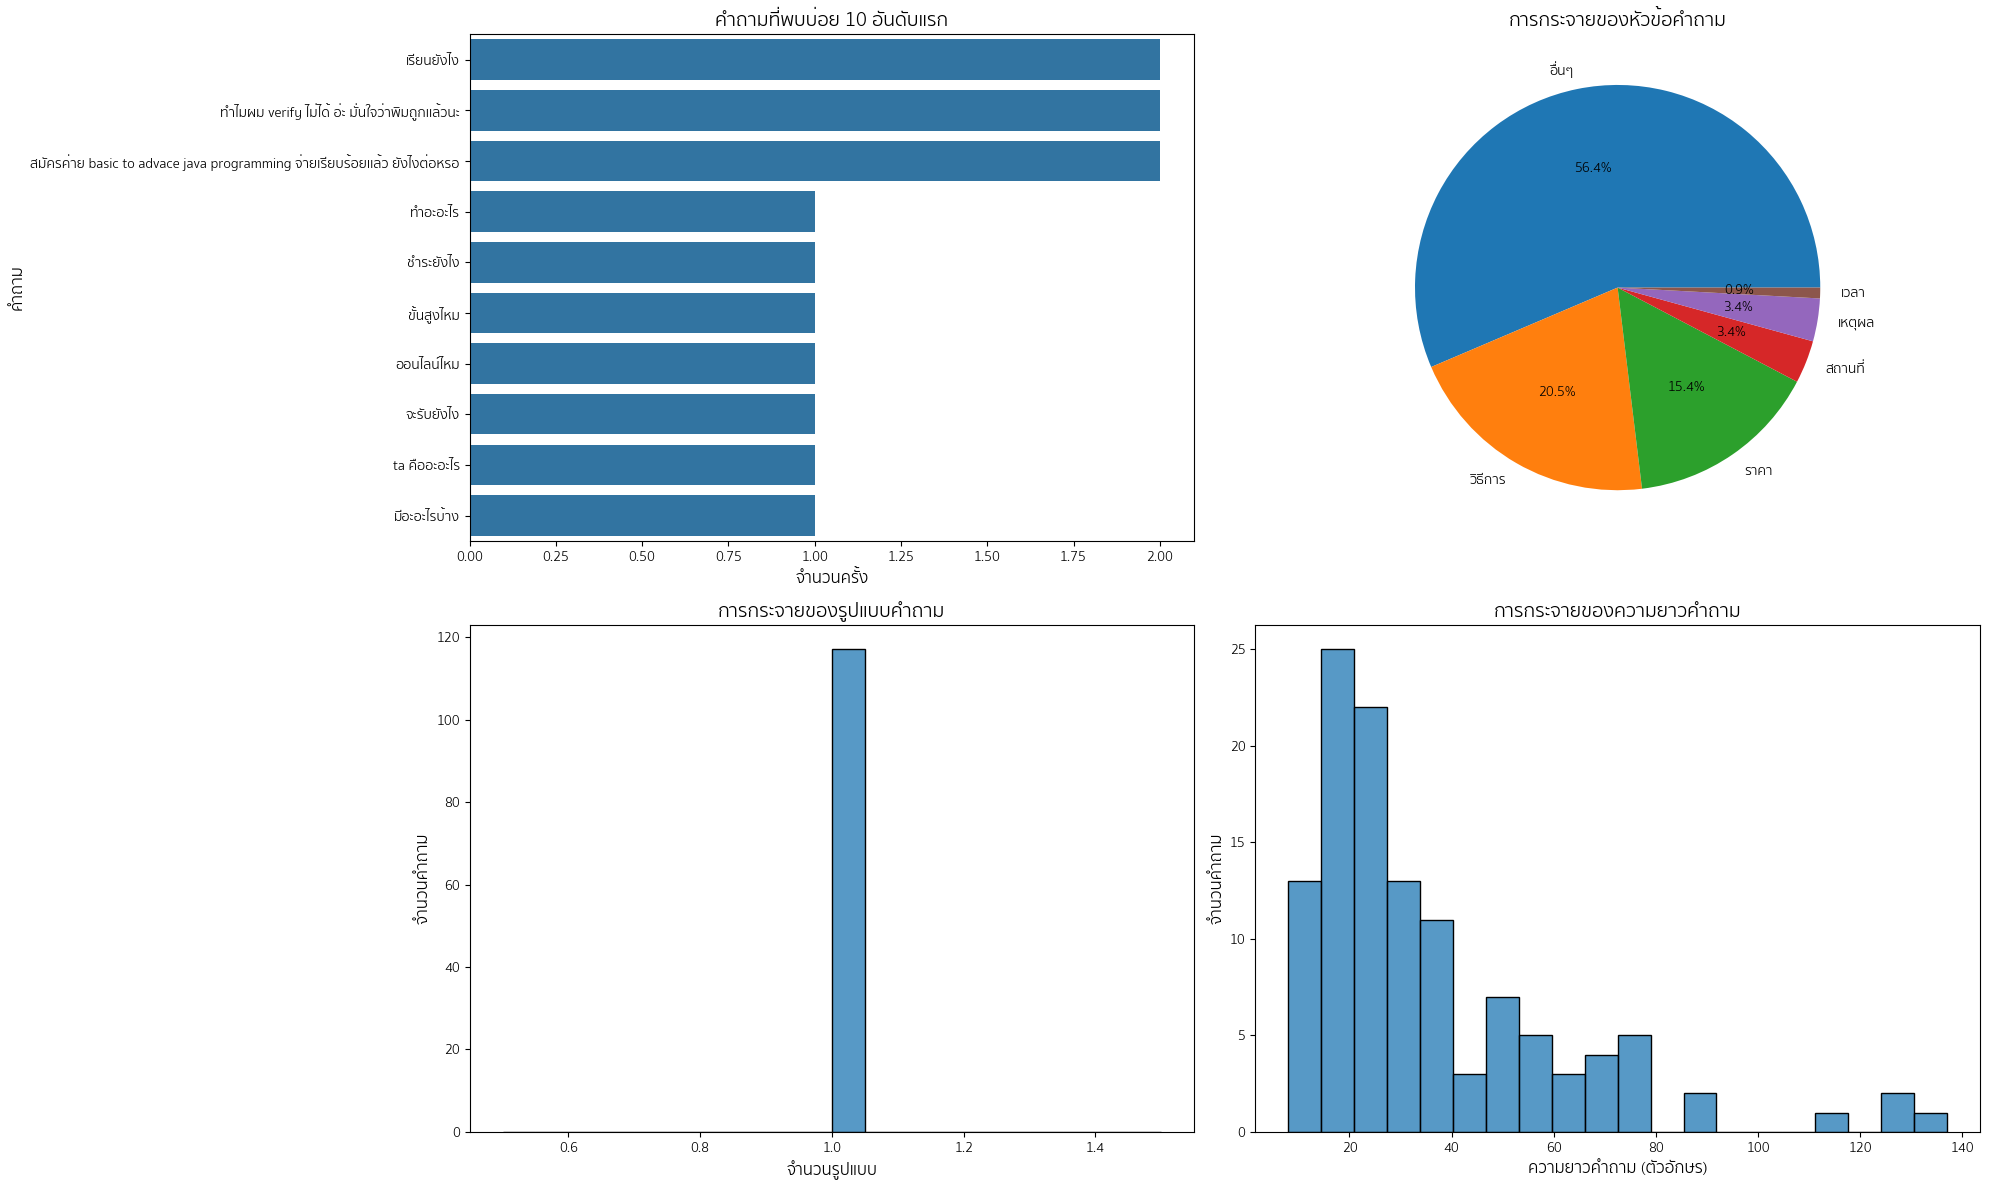

In [30]:
analyzer = ThaiQuestionAnalyzer()
analysis = analyzer.display_analysis(chats_df)

In [31]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from difflib import SequenceMatcher
import re
from typing import List, Dict, Tuple, Set
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class AdvancedThaiQuestionAnalyzer:
    def __init__(self):
        # Enhanced question patterns with sub-categories
        self.question_patterns = {
            'LEARNING_METHOD': {
                'patterns': [r'เรียนยังไง', r'สอนยังไง', r'วิธีเรียน', r'เรียนอย่างไร', r'สอนแบบไหน'],
                'sub_categories': {
                    'SELF_STUDY': [r'เรียนเอง', r'self', r'อ่านเอง'],
                    'INSTRUCTOR': [r'ครู', r'อาจารย์', r'ผู้สอน', r'สอน'],
                    'ONLINE': [r'ออนไลน์', r'วิดีโอ', r'คลิป'],
                    'OFFLINE': [r'ห้องเรียน', r'คลาส', r'ออฟไลน์']
                }
            },
            'CAREER_PROSPECT': {
                'patterns': [r'ทำงาน', r'อาชีพ', r'กำไร', r'รายได้', r'เงินเดือน'],
                'sub_categories': {
                    'SALARY': [r'เงินเดือน', r'รายได้', r'กำไร'],
                    'JOB_OPPORTUNITY': [r'งาน', r'ตำแหน่ง', r'สมัคร'],
                    'CAREER_PATH': [r'อาชีพ', r'เส้นทาง', r'อนาคต']
                }
            },
            'COURSE_CONTENT': {
                'patterns': [r'เรียนอะไร', r'คอร์ส', r'หลักสูตร', r'สอนอะไร', r'เนื้อหา'],
                'sub_categories': {
                    'CURRICULUM': [r'หลักสูตร', r'คอร์ส', r'เนื้อหา'],
                    'PREREQUISITES': [r'พื้นฐาน', r'ต้องรู้', r'ต้องเตรียม'],
                    'SKILLS': [r'ทักษะ', r'ความสามารถ', r'สกิล']
                }
            },
            'PRICE': {
                'patterns': [r'ราคา', r'กี่บาท', r'ค่าเรียน', r'ค่าใช้จ่าย'],
                'sub_categories': {
                    'COURSE_FEE': [r'ค่าเรียน', r'ค่าคอร์ส'],
                    'PAYMENT_TERMS': [r'ผ่อน', r'จ่าย', r'โอน'],
                    'DISCOUNTS': [r'ลด', r'โปรโมชั่น', r'แคมเปญ']
                }
            },
            'TIME': {
                'patterns': [r'กี่วัน', r'นานไหม', r'เมื่อไหร่', r'เวลา'],
                'sub_categories': {
                    'DURATION': [r'นานไหม', r'กี่วัน', r'กี่เดือน'],
                    'SCHEDULE': [r'ตาราง', r'เวลา', r'วันไหน'],
                    'START_DATE': [r'เริ่ม', r'รอบหน้า', r'รอบต่อไป']
                }
            }
        }

        # Enhanced keyword variations
        self.keyword_variations = {
            'เรียน': ['study', 'learn', 'เรียน', 'ศึกษา'],
            'ราคา': ['price', 'ค่า', 'บาท', 'ราคา', 'จ่าย'],
            'เวลา': ['time', 'duration', 'ระยะเวลา', 'นาน', 'กี่วัน'],
            'วิธี': ['how', 'method', 'way', 'วิธี', 'ยังไง', 'อย่างไร'],
            'งาน': ['job', 'work', 'career', 'อาชีพ', 'ทำงาน']
        }

        # Sentiment indicators
        self.sentiment_patterns = {
            'POSITIVE': [r'ดี', r'เยี่ยม', r'ชอบ', r'สนใจ', r'อยาก'],
            'NEGATIVE': [r'ยาก', r'แพง', r'นาน', r'ไม่', r'ไม่ได้'],
            'NEUTRAL': [r'ปกติ', r'ทั่วไป', r'พอดี']
        }

    def preprocess_text(self, text: str) -> str:
        """Enhanced text preprocessing"""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters but keep Thai characters
        text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z0-9\s]', ' ', str(text))
        # Normalize variations
        for base_word, variations in self.keyword_variations.items():
            for var in variations:
                text = text.replace(var, base_word)
        # Remove extra whitespace
        return ' '.join(text.split())

    def get_question_category(self, text: str) -> Dict[str, Dict]:
        """Get detailed question categorization"""
        results = {}
        normalized_text = self.preprocess_text(text)
        
        for category, data in self.question_patterns.items():
            # Check main category
            category_match = any(re.search(pattern, normalized_text) for pattern in data['patterns'])
            if category_match:
                results[category] = {
                    'matched': True,
                    'sub_categories': {}
                }
                # Check sub-categories
                for sub_cat, patterns in data['sub_categories'].items():
                    sub_match = any(re.search(pattern, normalized_text) for pattern in patterns)
                    results[category]['sub_categories'][sub_cat] = sub_match
                    
        return results

    def get_sentiment(self, text: str) -> str:
        """Analyze sentiment of the question"""
        normalized_text = self.preprocess_text(text)
        sentiments = {
            'POSITIVE': sum(bool(re.search(pattern, normalized_text)) for pattern in self.sentiment_patterns['POSITIVE']),
            'NEGATIVE': sum(bool(re.search(pattern, normalized_text)) for pattern in self.sentiment_patterns['NEGATIVE']),
            'NEUTRAL': sum(bool(re.search(pattern, normalized_text)) for pattern in self.sentiment_patterns['NEUTRAL'])
        }
        return max(sentiments.items(), key=lambda x: x[1])[0]

    def analyze_question_complexity(self, text: str) -> Dict:
        """Analyze question complexity"""
        word_count = len(text.split())
        char_count = len(text)
        has_multiple_questions = '?' in text and text.count('?') > 1
        
        return {
            'word_count': word_count,
            'char_count': char_count,
            'has_multiple_questions': has_multiple_questions,
            'complexity_score': min(1.0, (word_count / 20) + (char_count / 100))  # Normalized score
        }

    def analyze_questions(self, df: pd.DataFrame) -> Dict:
        """Comprehensive question analysis"""
        results = []
        
        for _, row in df.iterrows():
            text = str(row['message'])
            categories = self.get_question_category(text)
            sentiment = self.get_sentiment(text)
            complexity = self.analyze_question_complexity(text)
            
            analysis = {
                'original_text': text,
                'normalized_text': self.preprocess_text(text),
                'categories': categories,
                'sentiment': sentiment,
                'complexity': complexity
            }
            results.append(analysis)
        
        return self._generate_analysis_report(results)

    def _generate_analysis_report(self, results: List[Dict]) -> Dict:
        """Generate comprehensive analysis report"""
        # Convert results to DataFrame for easier analysis
        df_results = pd.DataFrame(results)
        
        # Category distribution
        category_counts = defaultdict(int)
        subcategory_counts = defaultdict(int)
        for result in results:
            for category, data in result['categories'].items():
                if data['matched']:
                    category_counts[category] += 1
                    for sub_cat, matched in data['sub_categories'].items():
                        if matched:
                            subcategory_counts[f"{category}_{sub_cat}"] += 1

        # Sentiment analysis
        sentiment_distribution = df_results['sentiment'].value_counts().to_dict()
        
        # Complexity analysis
        complexity_stats = {
            'avg_word_count': np.mean([r['complexity']['word_count'] for r in results]),
            'avg_char_count': np.mean([r['complexity']['char_count'] for r in results]),
            'multiple_questions_ratio': np.mean([r['complexity']['has_multiple_questions'] for r in results]),
            'avg_complexity_score': np.mean([r['complexity']['complexity_score'] for r in results])
        }

        # Pattern analysis
        pattern_stats = {
            'common_bigrams': self._get_common_patterns([r['normalized_text'] for r in results], 2),
            'common_trigrams': self._get_common_patterns([r['normalized_text'] for r in results], 3)
        }

        return {
            'sample_size': len(results),
            'category_distribution': dict(category_counts),
            'subcategory_distribution': dict(subcategory_counts),
            'sentiment_distribution': sentiment_distribution,
            'complexity_stats': complexity_stats,
            'pattern_stats': pattern_stats,
            'detailed_results': results
        }

    def _get_common_patterns(self, texts: List[str], n: int) -> Dict[str, int]:
        """Extract common n-grams from texts"""
        patterns = []
        for text in texts:
            words = text.split()
            for i in range(len(words) - n + 1):
                patterns.append(' '.join(words[i:i+n]))
        return dict(Counter(patterns).most_common(10))

    def generate_visualizations(self, analysis_results: Dict):
        """Generate comprehensive visualizations"""
        # Create a figure with subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Category Distribution
        plt.subplot(2, 2, 1)
        categories = analysis_results['category_distribution']
        plt.bar(categories.keys(), categories.values())
        plt.title('Question Category Distribution')
        plt.xticks(rotation=45)
        
        # 2. Sentiment Distribution
        plt.subplot(2, 2, 2)
        sentiments = analysis_results['sentiment_distribution']
        plt.pie(sentiments.values(), labels=sentiments.keys(), autopct='%1.1f%%')
        plt.title('Question Sentiment Distribution')
        
        # 3. Complexity Distribution
        plt.subplot(2, 2, 3)
        complexity_scores = [r['complexity']['complexity_score'] 
                           for r in analysis_results['detailed_results']]
        plt.hist(complexity_scores, bins=20)
        plt.title('Question Complexity Distribution')
        
        # 4. Subcategory Heatmap
        plt.subplot(2, 2, 4)
        subcategories = analysis_results['subcategory_distribution']
        subcategory_matrix = np.zeros((5, 3))  # Adjust size based on your subcategories
        # Fill matrix with values...
        sns.heatmap(subcategory_matrix, annot=True, fmt='g')
        plt.title('Subcategory Distribution Heatmap')
        
        plt.tight_layout()
        return fig

def perform_advanced_analysis(df: pd.DataFrame) -> Dict:
    """Perform complete advanced analysis"""
    analyzer = AdvancedThaiQuestionAnalyzer()
    analysis_results = analyzer.analyze_questions(df)
    
    # Print detailed report
    print("\n=== Advanced Question Analysis Report ===")
    print(f"\nTotal Questions Analyzed: {analysis_results['sample_size']}")
    
    print("\n1. Category Distribution:")
    for category, count in analysis_results['category_distribution'].items():
        print(f"{category}: {count} ({count/analysis_results['sample_size']*100:.1f}%)")
    
    print("\n2. Top Subcategories:")
    for subcat, count in sorted(
        analysis_results['subcategory_distribution'].items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:5]:
        print(f"{subcat}: {count}")
    
    print("\n3. Sentiment Analysis:")
    for sentiment, count in analysis_results['sentiment_distribution'].items():
        print(f"{sentiment}: {count} ({count/analysis_results['sample_size']*100:.1f}%)")
    
    print("\n4. Complexity Metrics:")
    for metric, value in analysis_results['complexity_stats'].items():
        print(f"{metric}: {value:.2f}")
    
    print("\n5. Common Patterns:")
    print("Top Bigrams:")
    for pattern, count in analysis_results['pattern_stats']['common_bigrams'].items():
        print(f"  - {pattern}: {count}")
    
    # Generate visualizations
    analyzer.generate_visualizations(analysis_results)
    
    return analysis_results


=== Advanced Question Analysis Report ===

Total Questions Analyzed: 1851

1. Category Distribution:
PRICE: 166 (9.0%)
COURSE_CONTENT: 16 (0.9%)
TIME: 33 (1.8%)

2. Top Subcategories:
TIME_SCHEDULE: 32
COURSE_CONTENT_CURRICULUM: 16
PRICE_PAYMENT_TERMS: 3
TIME_START_DATE: 2
COURSE_CONTENT_SKILLS: 1

3. Sentiment Analysis:
POSITIVE: 1710 (92.4%)
NEGATIVE: 139 (7.5%)
NEUTRAL: 2 (0.1%)

4. Complexity Metrics:
avg_word_count: 1.67
avg_char_count: 26.09
multiple_questions_ratio: 0.00
avg_complexity_score: 0.32

5. Common Patterns:
Top Bigrams:
  - basic to: 23
  - gmail com: 21
  - to advance: 20
  - game development: 13
  - advance game: 9
  - 21 00: 8
  - 18 00: 8
  - 00 21: 8
  - to advanced: 6
  - camphub in: 6


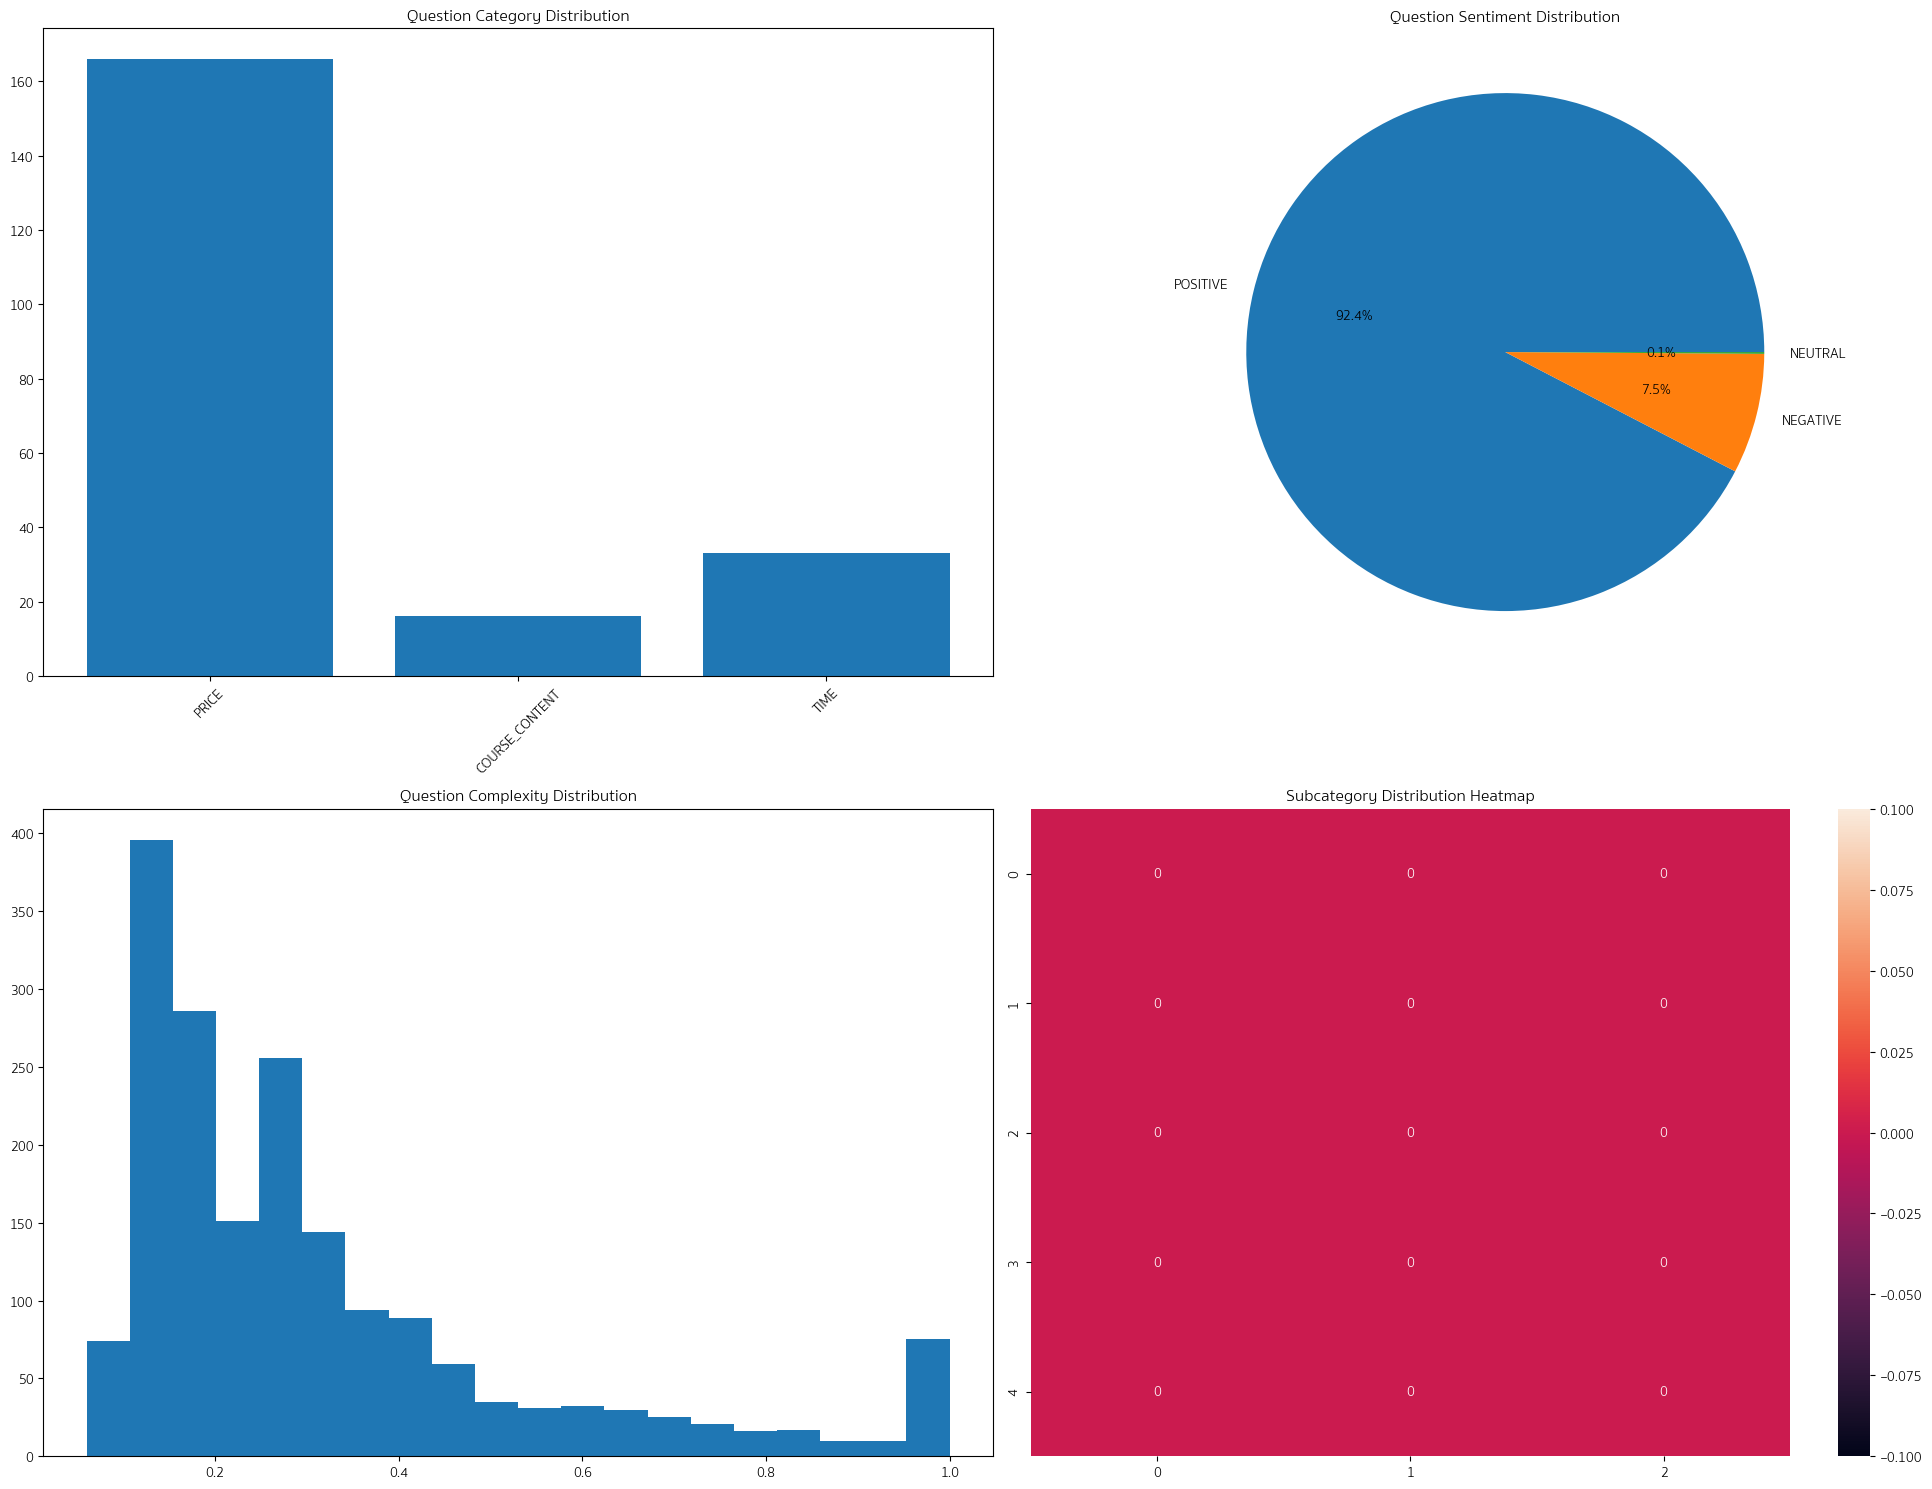

In [32]:
analysis_results = perform_advanced_analysis(chats_df)

# Topic Modeling

In [33]:
topic_modeling_df = chats_df.copy()

In [34]:
topic_modeling_df.head()

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
3        User          ☃️  2024/01/11  19:43:13   
6        User          ☃️  2024/01/11  19:47:50   
8        User          ☃️  2024/01/11  22:02:59   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
6                    11:59เที่ยงวันหรือเที่ยงคืนครับ  20240111_20240111_☃️   
8                              ต้องสมัครยังไงอ่ะครับ  20240111_20240111_☃️   

   account_name            datetime  hour  
0  LCS Official 2024-01-11 19:41:38    19  
1  LCS Official 2024-01-11 19:41:41    19  
3  LCS Official 2024-01-11 19:43:13    19  
6  LCS Official 2024-01-11 19:47:50    19  
8  LCS Official 2024-01-11 22:02:59    22

In [35]:
topic_modeling_df.shape

(1851, 9)

In [36]:
# Clean ['sender_type']
topic_modeling_df = topic_modeling_df[topic_modeling_df['sender_type'] == 'User']
topic_modeling_df.shape

(1851, 9)

In [37]:
# Drop 'account_name'
topic_modeling_df = topic_modeling_df.drop(columns=['account_name'])

In [38]:
topic_modeling_df.head()

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
3        User          ☃️  2024/01/11  19:43:13   
6        User          ☃️  2024/01/11  19:47:50   
8        User          ☃️  2024/01/11  22:02:59   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
6                    11:59เที่ยงวันหรือเที่ยงคืนครับ  20240111_20240111_☃️   
8                              ต้องสมัครยังไงอ่ะครับ  20240111_20240111_☃️   

             datetime  hour  
0 2024-01-11 19:41:38    19  
1 2024-01-11 19:41:41    19  
3 2024-01-11 19:43:13    19  
6 2024-01-11 19:47:50    19  
8 2024-01-11 22:02:59    22

In [39]:
topic_modeling_df.message.isna().sum()

0

## Cleaning

In [40]:
complete_text = topic_modeling_df.copy()

#Delete URLS from the original messsage 
complete_text['cleaned_text'] = complete_text['message'].replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)

# Remove all punctuation while preserving Thai characters and diacritics 
complete_text['cleaned_text'] = complete_text['cleaned_text'].str.replace(r'[^\u0E00-\u0E7F\w\s]', '', regex=True)

#Delete \n from the original messsage 
complete_text['cleaned_text'] = complete_text['cleaned_text'].str.replace('\n', '')

complete_text['english_text'] = complete_text['cleaned_text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x) if x is not None else x)
complete_text['english_text'] = complete_text['english_text'].apply(lambda x: re.sub(r'[0-9]', '', x) if x is not None else x)
# Split into list on ' ' of x is not None
complete_text['english_text'] = complete_text['english_text'].apply(lambda x: x.split(' ') if x is not None else x)
# Remove empty strings from englisgh_text 
complete_text['english_text'] = complete_text['english_text'].apply(lambda x: [i for i in x if i] if x is not None else x)
# Replace empty lists with np.nan 
complete_text['english_text'] = complete_text['english_text'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else np.nan)

# Remove English Characters from the cleaned_text
complete_text['cleaned_text'] = complete_text['cleaned_text'].apply(lambda x: re.sub(r'[a-zA-Z0-9]', '', x) if x is not None else x)

# Remove extra spaces ..
complete_text['cleaned_text'] = complete_text['cleaned_text'].str.replace(r' +', '', regex=True)

#Delete Spaces from the original message for tokenization
complete_text['cleaned_text'] = complete_text['cleaned_text'].str.replace(' ', '')

#Strip spaces
complete_text['cleaned_text'] = complete_text['cleaned_text'].str.strip()

# Replace empty strings with np.nan
complete_text['cleaned_text'] = complete_text['cleaned_text'].replace('', np.nan)

In [41]:
complete_text.head()

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
3        User          ☃️  2024/01/11  19:43:13   
6        User          ☃️  2024/01/11  19:47:50   
8        User          ☃️  2024/01/11  22:02:59   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
6                    11:59เที่ยงวันหรือเที่ยงคืนครับ  20240111_20240111_☃️   
8                              ต้องสมัครยังไงอ่ะครับ  20240111_20240111_☃️   

             datetime  hour  \
0 2024-01-11 19:41:38    19   
1 2024-01-11 19:41:41    19   
3 2024-01-11 19:43:13    19   
6 2024-01-11 19:47:50    19   
8 2024-01-11 22:02:59    22   

                                        cleaned_text english_text  
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมดวันหรือครับหรื...          NaN  
1                                          คุณส่งรูป          NaN  
3                                    เต็มหรือยังครับ          NaN  
6                         เที่ยงวันหรือเที่ยงคืนครับ          NaN  
8                              ต้องสมัครยังไงอ่ะครับ          NaN

## Tokenize

In [42]:
# Trie & Dict for Thai Names

custom_dict_thai_name = set(thai_words())
updated_words = ['กกต','มูฟออน','จนท', 'พลังประชารัฐ', 'สิบๆ', 'กวางกมลชนก', 'พันล้าน','มิย','อาร์ตพศุตม์','ไพจิตศรีวรขาน','แล้ว','จะ','ภูมิใจไทย','โมลนูพิราเวียร์','คำสิงห์','รศ','อัศวิณีย์','คำชะโนด','ธรรมนัส','บิวจักรพันธ์','พปชร','รทสช','วันนอร์','จุรินทร์',
                 'ชวนหลีกภัย','นิพิฏฐ์','ชัยธวัช','ม112','แคส','ชาวเน็ต','เน้นๆ','จันท์ชัยญา','อกริช','เน้น','ตาคลี','ชูวิทย์','เอ็ปสไตน์บาร์','หมอยง','ณัฐชา','มิลลิ','บุญยอด','ไก่พพาทินี','อดี','มีค','เต็มมี่','พษภาคม','ธาโรต์','เมย','ดาวเกตุ','ตัวบ้าน','ไผ่เมืองพล','มีค','มาแล้ว','อเทพ','ฟองเบียร์','วันนี้','พีระพันธุ์','วันชัยสอนสิริ','โพสต','สุดารัตน์','ยิ่งลักษณ์','ชินวัตร','เพื่อไทย','แยมฐปณีย์'
                 ,'ผบตร','กว่านี้','กฏหมาย','ตรีชฎา','พิธา','หรือไม่','อโกย','ตามคาด','หมอช้าง','ต๊ะนารากร','ทนายษิทรา','พอเหอะ','บิ๊กตู่','สุดแล้ว','วันนอร์','ไม่ถึง','ก็ต้อง','ทีนึง','พงศ์พรหม','แลนด์สไลด์','กำลัง','ถูกลอยแพ','ปานกามนิต','ทนายบอน','ไทยภักดี','จี้','เอาผิด','ร่วมรุ่น','รุ่น','บุญยอด','ทั้งหลาย','สารวัตรเอก','ในกติกา'
                 ,'ธนกร','ธรรมนัส','เสื้อแดง','เงียบไป','ทำไม','ลุงตู่','มาตรา112','ช่วงนี้','นอท','กองสลากพลัส','นิพิฏฐ์','ทำเถอะ','โทนี่','บุญยอด','กี่ประตู','กี่ขั้น','รธน','ไม่ได้','ราชกิจจาฯ','ฝาโลง','เชื่อมั่น','รังสิมันต์โรม','ไอทีวี','รองอธิการบดี','ปลอดประสพ','สภาฯ','ศิริกัญญา','อาบอบนวด','เมื่อไหร่','โบว์ณัฎฐา','ปารีณา','ป้านา','อาการ','ภาวะ','ใกล้ตัว','โฮสเทล','ตู้ห่าว','อวันนอร์','ดาวอาทิตย์','พอลภัทรพล','ออ๊อด','อวิชาการ','ของถูก','หม่อมปลื้ม','มาดามเดียร์','เป็นๆ','มาทั้ง'
                 ,'ม4','นายพลจ','มาเลย','เน้นๆ','สาวลับแล','พี่ต่าย','ออินทรี','ดุ่ยภรัญ','ปู่ซุ่ม','ภูพาน','อรรถชัย','อศราวุธ','ไทยพาณิชย์','เฉลิมชัย','อบอล','ราธา','แม่รุ่งตะวัน','อาจารย์เชษ','เมืองอุบล','ออินตาเพ็ชร','อประโคนชัย','อจอมยุทธ','ย่าโม','ชั่วๆ','เสรีพิศุทธ์','เต้มงคลกิตติ์','ยงยุทธ','แมนๆ','ปีไหน','อดีนุ้ย','พงศ์พรหม','ดุ่ยภรัญฯ','แมงปอ','พค','แพทองธาร','โบว์ณัฏฐา','ลุงเปลว','ชวนหลีกภัย','ทนายหงส์','สนธิลิ้มฯ','วันอยู่บำรุง','เสธหิ','รวมไทยสร้างชาติ','สมศักดิ์','สารคาม','พี่สาว','ธิปไตย'
                 ,'สถุน','ช็อคมิ้นต์','ลุงป้อม','บูลลี่','ธนาธร','สมชัย','สมยศ','สมเด็จฮุนเซน','ดิจิทัล','วอลเล็ต','รัชนก','อแนน','สหพัฒน์','วันชัย','จปัตตานี','อยะรัง','น้องกานต์','สุดารัตน์','โภคกุลกานนท์','พิทักษ์พรพัลลภ','เคราเงิน','ดรอานนท์','อเทพนาคราช','ไทยสร้างไทย','บันเลง','ไทยสร้างชาติ','พยาบาลสาว','คสช','รอบนี้','วางไว้','สมศักดิ์','อมรัตน์','พลอ','ชวลิตยงใจยุทธทำไม','ทวิต','ใจเย็นๆ','อลงกรณ์พลบุตร','แอ๊ดคาราบาว','อานนท์นำภา','อุ้มสิริยากร','อเจษฎา','สมชัย','อเนตร','อีเจี๊ยบเลียบด่วน','เจ๊ปองอัญชะลี','ชัยวุฒิ','ไม่อยู่','ขตบางเขน','ประเทศไทย','เจ๊นุ๊ก','พระพฤหัสบดี','เต็มมี่','ไอซ์รักชนก','นอยู่บำรุง','พี่วัน','ปู่ลำปลายมาศ'
                 ,'เฮียถนอม','เซราะกราว','กูย','หม้อใหญ่','ทักกี้','ธันวาไกรฤกษ์','ยี่ห้อ','โบโลน่า','ไปรเวท','บัวคำศรี','ชาติไทยพัฒนา','เพชรกรุณพล','คุณเดียร์','ครบถ้วน','เมพรีมายา','นักวิชาการ','นศ','นักการเมือง','ประชามติ','เด็ดๆ','อเนตร','อพาน','เจมส์สรรเพ็ชญ','นำทัพ','แล้วจะ','เสธหิ','ปิกาจู','เอโกมาราโดนา','บกลายจุด','ห้างฯ','จนท','สมเด็จพระกนิษฐาฯ','ทรงพระประชวร','โพสต์','เพื่อไทย','อดุ่ยภรัญ','มันหยด','ชัยเกษม','พร้อมเพย์','จงรู้','บรบือ','สดาวเด่น','พ่อเจริญศิลป์','เพชรกล้า','สายแข็ง','ลุงแป้น','เจ๊นุ๊ก','ออุดมธัญญาหาร','อสิง','แจ๊คเรือเกลือ','อลักษณ์ขนมทัย','อจอยดอกช้าง','เมย','ขตวัฒนา','มาดามเดียร์','ศักดิ์สยาม','โบว์ณัฏฐา'
                 ,'สูงกว่า','ไอทีวี','อุ๊หฤทัย','โอ้เอ๋ว','อีก','ลั่น', 'แสกน', 'แอป']  # Your updated words

# add flat list 

updated_words = updated_words 
custom_dict_thai_name.update(updated_words)
trie = dict_trie(dict_source=custom_dict_thai_name)

In [43]:
complete_text['tokens'] = complete_text['cleaned_text'].apply(pythainlp.tokenize.word_tokenize, 
                                                    engine="newmm", # Stochastic Model
                                                    keep_whitespace=True,
                                                    custom_dict=trie
                                                    )

## Stopwords

In [44]:
stopwords_import_list = list(thai_stopwords())

In [45]:
# Remove Stopwords from the all_tokens column
stopwords = list(thai_stopwords()) 

other_words = ['เดือน', 'วันที่', 'ปี', 'คน', 'ต่าง', 'สำหรับ', 
                'แบบนี้', 'ม', 'มกราคม', 'ตอนนี้', 'หรอก', 'กรกฎาคม', 
                'น้อง', 'รา', 'ต่าง ๆ', 'เดือน ไทย', 'บี', '์',
                "'", 'วันที่', 'ตรงนี่', 'พี่', 'คณะ', 'ที่จะ', 'อ่าน', 'อย่างไรก็ตาม', 'อีกครั้ง', 
                'เวลา', 'น', 'รีบ', 'ห้าม', 'ทำ', 'ภาพ', 'ฝั่ง', 'ดู', 'ผชน', 
                'ใด', 'บอ', 'รีนะคะ', 'อนุ', 'นะคะ', 'ค่ะ', 'คะ', 'อ่ะ', 'อ่ะ', 'ครับ', 'ครัช', 'moreinfographic',
                'ยังมี', 'อย่า', 'หา', 'รู้', 'หัว', 'ก้อ', 'ยืน', 'รอ', 'อิ', 'ล่ะ', 'อะ',  
                'ชัด', 'ดดสัด', 'หรา', 'ด่า', 'ดด', 'กะ', 'ยย', 'ร้า', 'หรอ',   
                'สิ', 'ลืม', 'วะ', 'กก', 'ใส่', 'งาน', 'ยัง', 'เค้า', 'กล้า', 'ชุด', 'น๊าาา', 'ค่า', 'ปัง', 'อันนี้', 'ป่ะ',  
                'น๊าาาา', 'ใจ', 'แสน', 'คนละ', 'ลูก', 'ไม่ต้อง', 'จ่ะ', 'อ่อ', 'ิใย', 'เหรอ', 'ฝ่า', 'ยอด',  
                'เท', 'ผม', 'ขอให้', 'นัด', 'โดน', 'ไทย', 'ไหม', 'ด่วน', 'นก', 'ตัวเอง', 'ชี้', 'เผย', 'ออกมา', 'ถาม', 'ๆ',
                'เรื่อง', 'มาจาก', 'เข้าไป', 'เข้ามา', 'โปรด', 'ไว', 'เหมือน', 'ปกติ', 'อ้างว่า', 'ปะ', 'แล้วจะ', 'อ่า', 'าา', 'เอ่ย', 'อุ้ย', 'เหรอ', 'น๊าา', 'ราคา',   
                'กุ', 'ตอน', 'ผม', 'ออกจาก', 'บางส่วน', 'บริเวณ', 'พลอ', 'พลอ.', 'พล.อ.', 'กลับมา', 'ล้าว', 'ล้า', 'พตอ.', 'พตอ', 'มั้ย', 'การ',
                'ยยยย', 'เเต่', 'แล้วก็', 'พรรค', '1', '2', '3', '5', '6', '4', '9' 'พี่น้องประชาชน', 'พี่น้อง', 'RT',
                'ดี','ขอบคุณ', 'ตัว']

other_words.extend(stopwords_import_list)
stopwords.extend(other_words)


complete_text['cleaned_tokenz'] = complete_text['tokens'].apply(lambda x: [item for item in x if item not in stopwords])
complete_text.head()

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
3        User          ☃️  2024/01/11  19:43:13   
6        User          ☃️  2024/01/11  19:47:50   
8        User          ☃️  2024/01/11  22:02:59   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
6                    11:59เที่ยงวันหรือเที่ยงคืนครับ  20240111_20240111_☃️   
8                              ต้องสมัครยังไงอ่ะครับ  20240111_20240111_☃️   

             datetime  hour  \
0 2024-01-11 19:41:38    19   
1 2024-01-11 19:41:41    19   
3 2024-01-11 19:43:13    19   
6 2024-01-11 19:47:50    19   
8 2024-01-11 22:02:59    22   

                                        cleaned_text english_text  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมดวันหรือครับหรื...          NaN   
1                                          คุณส่งรูป          NaN   
3                                    เต็มหรือยังครับ          NaN   
6                         เที่ยงวันหรือเที่ยงคืนครับ          NaN   
8                              ต้องสมัครยังไงอ่ะครับ          NaN   

                                              tokens  \
0  [เวิร์ก, ชิป, นี้, อ่ะ, ครับ, คือ, สอน, ทั้งหม...   
1                                    [คุณ, ส่ง, รูป]   
3                              [เต็ม, หรือยัง, ครับ]   
6                 [เที่ยงวัน, หรือ, เที่ยงคืน, ครับ]   
8                    [ต้อง, สมัคร, ยังไง, อ่ะ, ครับ]   

              cleaned_tokenz  
0  [เวิร์ก, ชิป, สอน, เลือก]  
1                      [รูป]  
3                     [เต็ม]  
6     [เที่ยงวัน, เที่ยงคืน]  
8                    [สมัคร]

In [46]:
complete_text['cleaned_tokenz'].isna().sum()

0

In [47]:
complete_text.head(2)

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   

             datetime  hour  \
0 2024-01-11 19:41:38    19   
1 2024-01-11 19:41:41    19   

                                        cleaned_text english_text  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมดวันหรือครับหรื...          NaN   
1                                          คุณส่งรูป          NaN   

                                              tokens  \
0  [เวิร์ก, ชิป, นี้, อ่ะ, ครับ, คือ, สอน, ทั้งหม...   
1                                    [คุณ, ส่ง, รูป]   

              cleaned_tokenz  
0  [เวิร์ก, ชิป, สอน, เลือก]  
1                      [รูป]

## POS Tagging

In [48]:
# POS Tagging

def pos_tagging(row):
    if isinstance(row['cleaned_tokenz'], list) and len(row['cleaned_tokenz']) > 0:
        return pythainlp.tag.pos_tag(row['cleaned_tokenz'], engine='perceptron', corpus='orchid_ud')
    else:
        return np.nan


complete_text['tokens_pos_tags'] = complete_text.apply(pos_tagging, axis=1)


In [49]:
keeps_pos = ['NOUN', 'VERB']

def keep_pos_tags(row):
    if isinstance(row['tokens_pos_tags'], list) and len(row['tokens_pos_tags']) > 0:
        return [i[0] for i in row['tokens_pos_tags'] if i[1] in keeps_pos]
    else:
        return np.nan


complete_text['all_cleaned_tokens_pos'] = complete_text.apply(keep_pos_tags, axis=1)

In [50]:
complete_text[complete_text['all_cleaned_tokens_pos'].isnull()] 

sender_type       sender_name        date      time  \
12          User                ☃️  2024/01/11  22:18:51   
15          User                ☃️  2024/01/11  22:21:36   
17          User   Arm (Kittikhun)  2024/10/03  22:35:47   
25          User               eel  2024/04/18  20:28:22   
29          User               eel  2024/08/06  08:31:24   
...          ...               ...         ...       ...   
3794        User           Unknown  2024/03/22  16:48:19   
3811        User           Unknown  2024/03/22  16:56:25   
3817        User           Unknown  2024/03/22  17:35:42   
3838        User  Aei_Boston_Beiya  2024/04/19  00:10:55   
3890        User        Ittinut R.  2024/07/30  20:41:18   

                           message                         source_file  \
12                         ทำอะไร*                20240111_20240111_☃️   
15                      ขอบคุณครับ                20240111_20240111_☃️   
17             ผมลืม username ครับ   20241003_20241003_Arm (Kittikhun)   
25                      ขอบคุณครับ               20240418_20240807_eel   
29    email sirapob.book@gmail.com               20240418_20240807_eel   
...                            ...                                 ...   
3794                   ได้รับไหมคะ           20240315_20240322_Unknown   
3811                           ค่ะ           20240315_20240322_Unknown   
3817             ขึ้นมาอย่างนี้ค่ะ           20240315_20240322_Unknown   
3838   ขอบคุณค่ะ ไว้ดูเวลาอื่นค่ะ   20240418_20240419_Aei_Boston_Beiya   
3890                         /help        20240730_20240730_Ittinut R.   

                datetime  hour               cleaned_text  \
12   2024-01-11 22:18:51    22                     ทำอะไร   
15   2024-01-11 22:21:36    22                 ขอบคุณครับ   
17   2024-10-03 22:35:47    22                  ผมลืมครับ   
25   2024-04-18 20:28:22    20                 ขอบคุณครับ   
29   2024-08-06 08:31:24     8                        NaN   
...                  ...   ...                        ...   
3794 2024-03-22 16:48:19    16                ได้รับไหมคะ   
3811 2024-03-22 16:56:25    16                        ค่ะ   
3817 2024-03-22 17:35:42    17          ขึ้นมาอย่างนี้ค่ะ   
3838 2024-04-19 00:10:55     0  ขอบคุณค่ะไว้ดูเวลาอื่นค่ะ   
3890 2024-07-30 20:41:18    20                        NaN   

                      english_text                                   tokens  \
12                             NaN                               [ทำ, อะไร]   
15                             NaN                           [ขอบคุณ, ครับ]   
17                      [username]                          [ผม, ลืม, ครับ]   
25                             NaN                           [ขอบคุณ, ครับ]   
29    [email, sirapobbookgmailcom]                                       []   
...                            ...                                      ...   
3794                           NaN                        [ได้รับ, ไหม, คะ]   
3811                           NaN                                    [ค่ะ]   
3817                           NaN                [ขึ้น, มา, อย่างนี้, ค่ะ]   
3838                           NaN  [ขอบคุณ, ค่ะ, ไว้, ดู, เวลา, อื่น, ค่ะ]   
3890                        [help]                                       []   

     cleaned_tokenz tokens_pos_tags all_cleaned_tokens_pos  
12               []             NaN                    NaN  
15               []             NaN                    NaN  
17               []             NaN                    NaN  
25               []             NaN                    NaN  
29               []             NaN                    NaN  
...             ...             ...                    ...  
3794             []             NaN                    NaN  
3811             []             NaN                    NaN  
3817             []             NaN                    NaN  
3838             []             NaN                    NaN  
3890             []             NaN       

In [51]:
full_complete_text = complete_text.dropna(subset=['all_cleaned_tokens_pos'])

In [52]:
full_complete_text.head()

sender_type sender_name        date      time  \
0        User          ☃️  2024/01/11  19:41:38   
1        User          ☃️  2024/01/11  19:41:41   
3        User          ☃️  2024/01/11  19:43:13   
6        User          ☃️  2024/01/11  19:47:50   
8        User          ☃️  2024/01/11  22:02:59   

                                             message           source_file  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมด3วันหรือครับหร...  20240111_20240111_☃️   
1                                          คุณส่งรูป  20240111_20240111_☃️   
3                                    เต็มหรือยังครับ  20240111_20240111_☃️   
6                    11:59เที่ยงวันหรือเที่ยงคืนครับ  20240111_20240111_☃️   
8                              ต้องสมัครยังไงอ่ะครับ  20240111_20240111_☃️   

             datetime  hour  \
0 2024-01-11 19:41:38    19   
1 2024-01-11 19:41:41    19   
3 2024-01-11 19:43:13    19   
6 2024-01-11 19:47:50    19   
8 2024-01-11 22:02:59    22   

                                        cleaned_text english_text  \
0  เวิร์กชิปนี้อ่ะครับคือสอนทั้งหมดวันหรือครับหรื...          NaN   
1                                          คุณส่งรูป          NaN   
3                                    เต็มหรือยังครับ          NaN   
6                         เที่ยงวันหรือเที่ยงคืนครับ          NaN   
8                              ต้องสมัครยังไงอ่ะครับ          NaN   

                                              tokens  \
0  [เวิร์ก, ชิป, นี้, อ่ะ, ครับ, คือ, สอน, ทั้งหม...   
1                                    [คุณ, ส่ง, รูป]   
3                              [เต็ม, หรือยัง, ครับ]   
6                 [เที่ยงวัน, หรือ, เที่ยงคืน, ครับ]   
8                    [ต้อง, สมัคร, ยังไง, อ่ะ, ครับ]   

              cleaned_tokenz  \
0  [เวิร์ก, ชิป, สอน, เลือก]   
1                      [รูป]   
3                     [เต็ม]   
6     [เที่ยงวัน, เที่ยงคืน]   
8                    [สมัคร]   

                                     tokens_pos_tags  \
0  [(เวิร์ก, NOUN), (ชิป, NOUN), (สอน, VERB), (เล...   
1                                      [(รูป, NOUN)]   
3                                     [(เต็ม, VERB)]   
6             [(เที่ยงวัน, NOUN), (เที่ยงคืน, NOUN)]   
8                                    [(สมัคร, NOUN)]   

      all_cleaned_tokens_pos  
0  [เวิร์ก, ชิป, สอน, เลือก]  
1                      [รูป]  
3                     [เต็ม]  
6     [เที่ยงวัน, เที่ยงคืน]  
8                    [สมัคร]

In [53]:
full_complete_text.shape

(1529, 14)

## Pre Modeling

In [54]:
docs = full_complete_text['all_cleaned_tokens_pos'].to_list()

docs = [ele for ele in docs if ele != []]
docs = [ele for ele in docs if len(ele) >= 2] #Filter out sparse tweets

In [55]:
len(docs)

778

In [59]:
dictionary = gensim.corpora.Dictionary(docs)
print(len(dictionary))
dictionary.filter_extremes(no_below=3, no_above=0.8, keep_n=400000)
vocab_length = len(dictionary)
print(len(dictionary))

2024-11-27 13:21:15 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2024-11-27 13:21:15 - INFO - built Dictionary<763 unique tokens: ['ชิป', 'สอน', 'เลือก', 'เวิร์ก', 'เที่ยงคืน']...> from 778 documents (total 2625 corpus positions)
2024-11-27 13:21:15 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<763 unique tokens: ['ชิป', 'สอน', 'เลือก', 'เวิร์ก', 'เที่ยงคืน']...> from 778 documents (total 2625 corpus positions)", 'datetime': '2024-11-27T13:21:15.589850', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]', 'platform': 'macOS-15.0-arm64-arm-64bit', 'event': 'created'}
2024-11-27 13:21:15 - INFO - discarding 595 tokens: [('ชิป', 1), ('เวิร์ก', 1), ('เที่ยงคืน', 1), ('เที่ยงวัน', 1), ('ออ', 2), ('ค้า', 2), ('เช็ค', 2), ('ไฟล์', 2), ('ปิดเทอม', 2), ('พค', 1)]...
2024-11-27 13:21:15 - INFO - keeping 168 tokens which were in no less than 3 and no more than 622 (=80.0%) documents
2024-11-27 13:21:15 - INFO - resulting dictionar

763
168


In [60]:
# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

### GSDMM

In [88]:
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=500)
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
y = mgp.fit(docs, n_terms)

In stage 0: transferred 643 clusters with 10 clusters populated
In stage 1: transferred 381 clusters with 10 clusters populated
In stage 2: transferred 295 clusters with 10 clusters populated
In stage 3: transferred 255 clusters with 10 clusters populated
In stage 4: transferred 240 clusters with 10 clusters populated
In stage 5: transferred 218 clusters with 10 clusters populated
In stage 6: transferred 208 clusters with 10 clusters populated
In stage 7: transferred 206 clusters with 10 clusters populated
In stage 8: transferred 196 clusters with 10 clusters populated
In stage 9: transferred 199 clusters with 10 clusters populated
In stage 10: transferred 205 clusters with 10 clusters populated
In stage 11: transferred 204 clusters with 10 clusters populated
In stage 12: transferred 202 clusters with 10 clusters populated
In stage 13: transferred 219 clusters with 10 clusters populated
In stage 14: transferred 211 clusters with 10 clusters populated
In stage 15: transferred 205 cluste

In [89]:
import tqdm
# helper functions
def top_words(cluster_word_distribution, top_cluster, values):
    '''prints the top words in each cluster'''
    for cluster in top_cluster:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — —')

def cluster_importance(mgp):
    '''returns a word-topic matrix[phi] where each value represents
    the word importance for that particular cluster;
    phi[i][w] would be the importance of word w in topic i.
    '''
    n_z_w = mgp.cluster_word_distribution
    beta, V, K = mgp.beta, mgp.vocab_size, mgp.K
    phi = [{} for i in range(K)]
    for z in range(K):
        for w in n_z_w[z]:
            phi[z][w] = (n_z_w[z][w]+beta)/(sum(n_z_w[z].values())+V*beta)
    return phi

def topic_allocation(df, docs, mgp, topic_dict):
    '''allocates all topics to each document in original dataframe,
    adding two columns for cluster number and cluster description'''
    topic_allocations = []
    for doc in tqdm(docs):
        topic_label, score = mgp.choose_best_label(doc)
        topic_allocations.append(topic_label)

    df['cluster'] = topic_allocations

    df['topic_name'] = df.cluster.apply(lambda x: get_topic_name(x, topic_dict))
    print('Complete. Number of documents with topic allocated: {}'.format(len(df)))

def get_topic_name(doc, topic_dict):
    '''returns the topic name string value from a dictionary of topics'''
    topic_desc = topic_dict[doc]
    return topic_desc

In [90]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)

# topics sorted by the number of documents they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):',   
       top_index)
print('*'*20)

# show the top 10 words in term frequency for each cluster 
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
top_words(mgp.cluster_word_distribution, topic_indices, 10)

Number of documents per topic : [ 85  23  28 200  38 104  76  20 109  95]
********************
Most important clusters (by number of docs inside): [3 8 5 9 0 6 4 2 1 7]
********************
Cluster 0 : [('สมัคร', 21), ('จ่าย', 19), ('ค่าย', 18), ('บัตร', 18), ('เกียรติ', 17), ('ไห', 15), ('นคะ', 13), ('สวัสดี', 8), ('เงิน', 7), ('เข้าเรียน', 6)]
 — — — — — — — — —
Cluster 1 : [('ค่าย', 10), ('เกม', 7), ('โปรแกรม', 5), ('สร้าง', 5), ('สอน', 4), ('\r\r', 4), ('โห', 3), ('บด', 3), ('สอบถาม', 3), ('มินิ', 2)]
 — — — — — — — — —
Cluster 2 : [('่', 18), ('แม่', 14), ('หนู', 9), ('ค่าย', 8), ('คืน', 7), ('ตอบ', 7), ('โอน', 6), ('เงิน', 5), ('งับ', 4), ('รถ', 3)]
 — — — — — — — — —
Cluster 3 : [('เรียน', 63), ('ค่าย', 54), ('สมัคร', 32), ('สนใจ', 23), ('พื้นฐาน', 23), ('สอบถาม', 21), ('โมง', 20), ('หนู', 19), ('สอน', 15), ('ทราบ', 12)]
 — — — — — — — — —
Cluster 4 : [('เรียน', 15), ('เ', 8), ('สอบถาม', 7), ('คอม', 6), ('ซื้อ', 5), ('วิศวะ', 5), ('ภัทร', 3), ('สัก', 3), ('อาจารย์', 3), ('โน๊ตบุ

In [91]:
def get_topic_words(mgp, top_n=10):
    topic_words = []
    for topic_distribution in mgp.cluster_word_distribution:
        sorted_words = sorted(topic_distribution.items(), key=lambda x: x[1], reverse=True)[:top_n]
        topic_words.append([word for word, _ in sorted_words])
    return topic_words

# Example usage
topic_words = get_topic_words(mgp, top_n=10)


# Calculate coherence
def calculate_coherence(topic_words, docs, dictionary, coherence_type='c_v'):
    '''returns the coherence value for the model'''
    cm = CoherenceModel(topics=topic_words, texts=docs, dictionary=dictionary, coherence=coherence_type)
    coherence = cm.get_coherence()
    return coherence

coherence = calculate_coherence(topic_words, docs, dictionary, coherence_type='c_v')

print('Coherence:', coherence)

2024-11-27 13:49:14 - INFO - using ParallelWordOccurrenceAccumulator<processes=9, batch_size=64> to estimate probabilities from sliding windows
python(11993) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11994) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12002) MallocStackLogging: can't turn off malloc stack logging be

Coherence: 0.4345201740303007


### NMF

In [92]:
### NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [101]:
# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Convert list of tokens to strings for TF-IDF vectorization
docs_text = [' '.join(doc) for doc in docs]

# Create TF-IDF vectorizer with Thai-specific settings
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit features to prevent sparsity
    max_df=0.95,        # Remove terms that appear in >95% of docs
    min_df=2,           # Remove terms that appear in <2 docs
    lowercase=False,    # Don't lowercase since we're dealing with Thai
    token_pattern=r'[^\s]+',  # Pattern that matches Thai words
)

# Create document-term matrix
dtm = tfidf_vectorizer.fit_transform(docs_text)

# Initialize and fit NMF model
n_topics = 10  # Same number of topics as your GSDMM
nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    init='nndsvd',     # Better initialization for sparse data
    max_iter=500       # Maximum number of iterations
)

# Fit the model
doc_topic_matrix = nmf_model.fit_transform(dtm)

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print top words for each topic
n_top_words = 25
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    
# Get topic distribution for each document
doc_topics = nmf_model.transform(dtm)

Topic 1: ประจำเดือน, ตารางเรียน, ่, บ่าย, นึง, บ, บด, บัญชี, บัตร, บุญ, ป, ทุ่ม, ประกาศนียบัตร, ปรึกษา, ปลาย, ปิดเทอม, ป่าว, นคะ, ทีม, ผลงาน, ทำเป็น, ทำกิจกรรม, ทำการ, ทัก, ทราบ
Topic 2: เรียน, โมง, พื้นฐาน, สนใจ, คอม, ชม, ทราบ, ช่องทาง, วิศวะ, นคะ, ไห, ลูกชาย, ไลน, มิถุนายน, กำหนดการ, ซื้อ, สอน, หมายถึง, คอร์ส, ะ, สะดวก, ค, ป, แทน, แชร์
Topic 3: ตัวต่อตัว, ปรึกษา, ค่าเรียน, อัตรา, ครูผู้สอน, มหาลัย, ทัก, ชำระเงิน, นคะ, ไห, เด็ก, เ, รายการ, คุณแม่, คุย, สนใจ, ข้อความ, บ่าย, โทรศัพท์, เอ, สถาบัน, หน่วยงาน, ท, อายุ, กด
Topic 4: ค่าย, สนใจ, เต็ม, เกม, ทราบ, ออนไลน์, ภาษา, การเรียน, รับสมัคร, จ่าย, พื้นฐาน, คลิป, จบ, เมล, ว่าง, คอมพิวเตอร์, แนะนำ, เงิน, เเล้ว, ทีม, โรงเรียน, โครงการ, สลิป, สร้าง, ่
Topic 5: สมัคร, จ่าย, ลูกชาย, ครับผม, เดี๋ยว, เต็ม, เงิน, เว็บ, โปรแกรม, คับ, เข้าเรียน, แคมป์, กิจกรรม, นคะ, ไห, อีเมล, งั้น, ลิงค์, ดิส, คอด, พื้นฐาน, โอน, เเล้ว, ชำระ, เด็ก
Topic 6: โอเค, ร, คับ, ครับผม, บ, เค, เดี๋ยว, งั้น, การเรียน, ะ, อ๋า, สอน, ออ, ขอบ, คุณค่า, า, ศุกร์, อ้อ, โอน, แม่, โปร


Topic Coherence Score: 0.1405


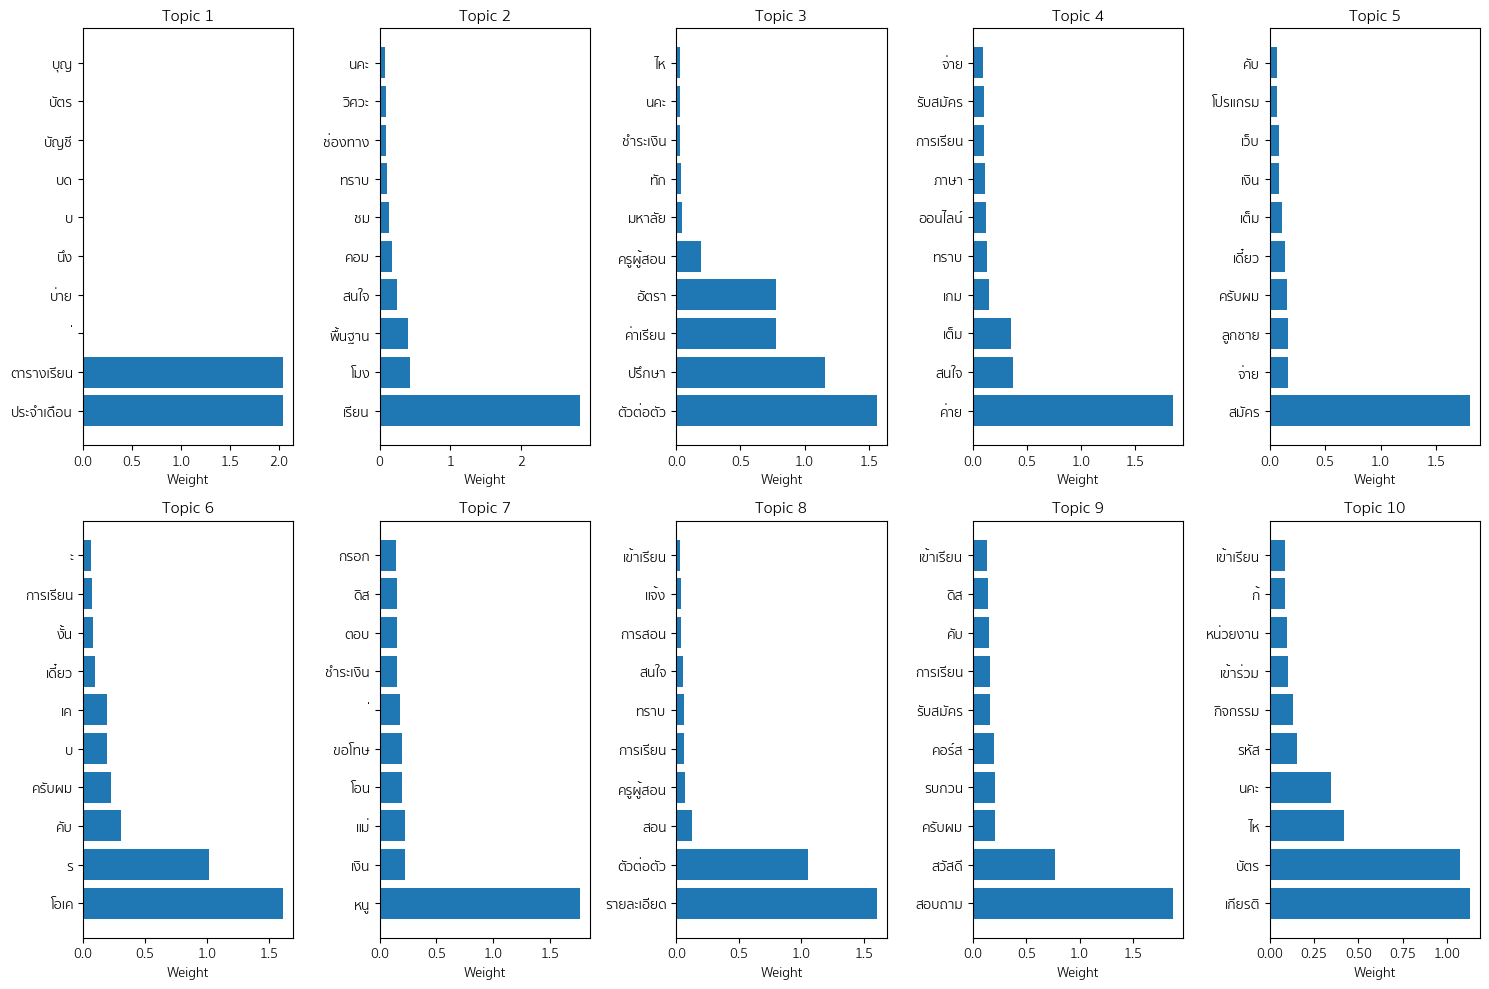

In [102]:
# Calculate topic coherence
from sklearn.metrics.pairwise import cosine_similarity

def calculate_topic_coherence(components, feature_names, top_n=10):
    """Calculate average pairwise cosine similarity between top words in each topic"""
    coherence_scores = []
    
    for topic in components:
        top_word_indices = topic.argsort()[:-top_n-1:-1]
        topic_words = components[:, top_word_indices]
        similarity_matrix = cosine_similarity(topic_words)
        
        # Calculate average similarity
        coherence = (similarity_matrix.sum() - similarity_matrix.shape[0]) / (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
        coherence_scores.append(coherence)
    
    return np.mean(coherence_scores)

# Calculate and print coherence
coherence = calculate_topic_coherence(nmf_model.components_, feature_names)
print(f"\nTopic Coherence Score: {coherence:.4f}")

# Visualize topic-word distributions
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_word_distribution(model, feature_names, n_top_words=10):
    plt.figure(figsize=(15, 10))
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        weights = topic[top_words_idx]
        
        plt.subplot(2, 5, topic_idx + 1)
        plt.barh(top_words, weights)
        plt.title(f'Topic {topic_idx + 1}')
        plt.xlabel('Weight')
    
    plt.tight_layout()
    plt.show()

# Plot topic-word distributions
plot_topic_word_distribution(nmf_model, feature_names)

In [104]:
# Method 1: Using gensim's coherence model (recommended)
from gensim.models.coherencemodel import CoherenceModel

def get_topic_words(nmf_model, feature_names, top_n=10):
    """Extract top words for each topic from NMF model"""
    topic_words = []
    for topic in nmf_model.components_:
        top_word_indices = topic.argsort()[:-top_n-1:-1]
        topic_words.append([feature_names[i] for i in top_word_indices])
    return topic_words

# Get topic words
topic_words = get_topic_words(nmf_model, feature_names, top_n=10)

# Calculate coherence using different metrics
coherence_metrics = ['c_v', 'c_npmi', 'c_uci', 'u_mass']
coherence_scores = {}

for metric in coherence_metrics:
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=docs,  # Your original tokenized documents
        dictionary=dictionary,  # Your gensim dictionary
        coherence=metric
    )
    coherence_scores[metric] = coherence_model.get_coherence()

print("\nCoherence Scores:")
for metric, score in coherence_scores.items():
    print(f"{metric}: {score:.4f}")

# Method 2: Using cosine similarity (simpler but less standard)
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_topic_coherence_cosine(components, feature_names, top_n=10):
    """Calculate topic coherence using cosine similarity between top words"""
    coherence_scores = []
    
    for topic in components:
        # Get top words indices
        top_word_indices = topic.argsort()[:-top_n-1:-1]
        topic_words = components[:, top_word_indices]
        
        # Calculate pairwise similarities
        similarity_matrix = cosine_similarity(topic_words)
        
        # Calculate average similarity (excluding self-similarity)
        n = similarity_matrix.shape[0]
        coherence = (similarity_matrix.sum() - n) / (n * (n - 1))
        coherence_scores.append(coherence)
    
    return {
        'mean_coherence': np.mean(coherence_scores),
        'per_topic_coherence': coherence_scores
    }

# Calculate coherence using cosine similarity
cosine_coherence = calculate_topic_coherence_cosine(
    nmf_model.components_, 
    feature_names
)


2024-11-27 13:57:50 - INFO - using ParallelWordOccurrenceAccumulator<processes=9, batch_size=64> to estimate probabilities from sliding windows


python(12541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2024-11-27 13:57:51 - INFO - 9 accumulators retrieved from output queue
2024-11-27 13:57:51 - INFO - accumulated word 


Coherence Scores:
c_v: 0.3979
c_npmi: -0.3042
c_uci: -10.9433
u_mass: -15.0935



Cosine Similarity Based Coherence:
Mean coherence: 0.1405

Per-topic coherence scores:
Topic 1: 0.1219
Topic 2: 0.2123
Topic 3: 0.1034
Topic 4: 0.2034
Topic 5: 0.0748
Topic 6: 0.1114
Topic 7: 0.1005
Topic 8: 0.1663
Topic 9: 0.1118
Topic 10: 0.1989


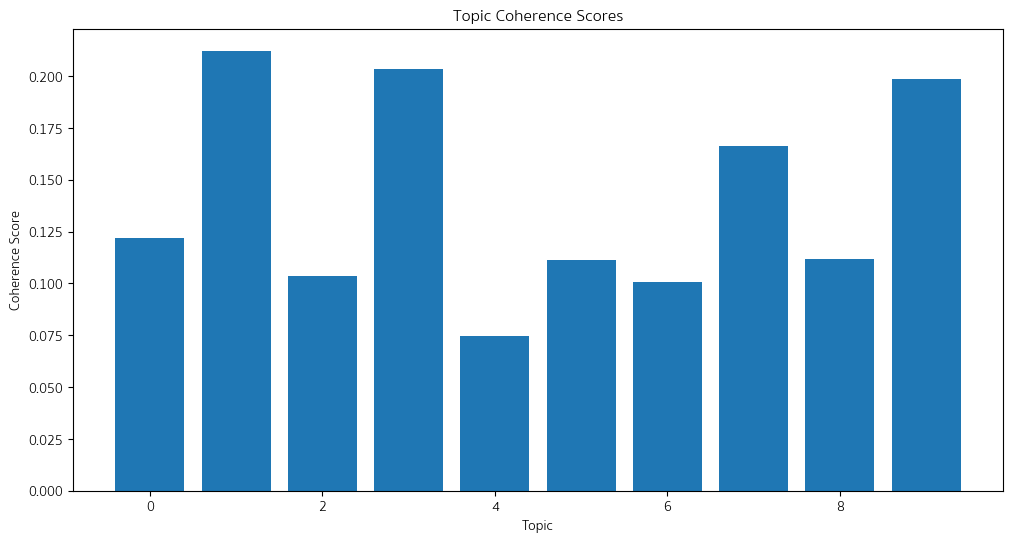

In [105]:

print("\nCosine Similarity Based Coherence:")
print(f"Mean coherence: {cosine_coherence['mean_coherence']:.4f}")
print("\nPer-topic coherence scores:")
for i, score in enumerate(cosine_coherence['per_topic_coherence']):
    print(f"Topic {i+1}: {score:.4f}")

# Visualize coherence scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(cosine_coherence['per_topic_coherence'])), 
        cosine_coherence['per_topic_coherence'])
plt.title('Topic Coherence Scores')
plt.xlabel('Topic')
plt.ylabel('Coherence Score')
plt.show()